<h1>☀️Unlocking the Power of Time Series Analysis with Weather data and Temperature Forecasting🌦️</h1>

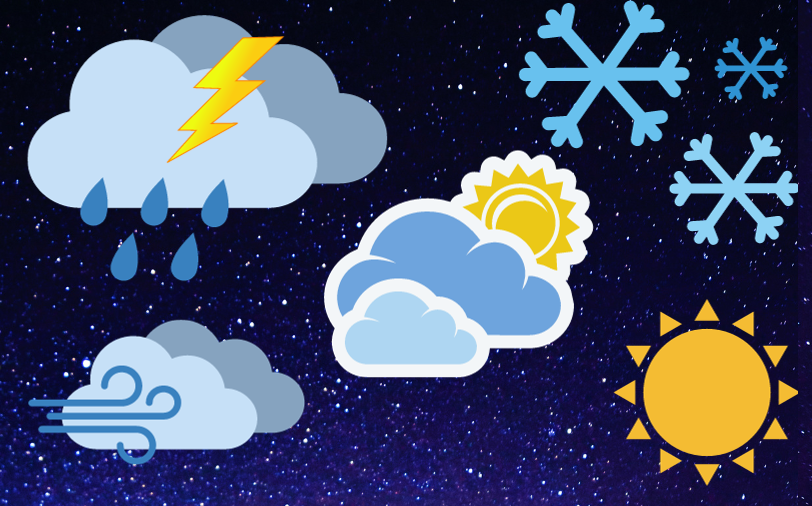

### Downloading Kaggle Dataset - on Kaggle

Under the Data section add dataset/s to use for your analysis

---
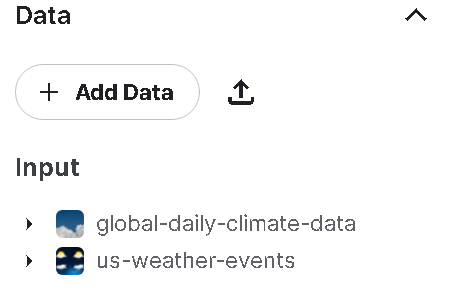

---
<blockquote>
Kaggle API Token (kaggle.json) to download the Weather Datasets - this was required when using the Google Colab Notebook - not necessary for the Kaggle notebook.

More details on Kaggle API can be found
https://github.com/Kaggle/kaggle-api
</blockquote>    

## Import Modules

In [1]:
import numpy as np
import pandas as pd
from pandas.plotting import lag_plot

import seaborn as sns
sns.set(color_codes=True)

import matplotlib.pyplot as plt
%matplotlib inline

import geopandas as gpd
import geoplot

from dateutil.parser import parse

In [3]:
from scipy import signal

from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error


# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
#from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.layers import Dense, LSTM#, Conv1D, Lambda, Reshape, RNN, LSTMCell

from prophet import Prophet

<blockquote>
I decided on these datasets because I wanted to work with weather\climate data because I am interested in the Climate tech industry.
I wanted to work on time series analysis because I wanted to review the data to answers questions similar to those noted below:

POV Climate Researchers:
 	
What are the trends in weather patterns over the years?
Can we correlate changes in weather with broader climate change indicators?
Are there areas/regions experiencing more severe weather fluctuations?
Can we model future climate 	scenarios based on this data?
</blockquote>

### Read Files 
##### 2 datasets - 4 files - 3 CSVs - 1 parquet

[The Weather Dataset](https://www.kaggle.com/datasets/guillemservera/global-daily-climate-data?select=cities.csv) - 3 files

In [6]:
# dataset 1 - CSV
countries_data = pd.read_csv('/kaggle/input/global-daily-climate-data/countries.csv')
gbl_cities_data = pd.read_csv('/kaggle/input/global-daily-climate-data/cities.csv')

# dataset 1 - parquet file
gbl_weather_data = pd.read_parquet('/kaggle/input/global-daily-climate-data/daily_weather.parquet')

[US Weather Events (2016 - 2022)](https://www.kaggle.com/datasets/sobhanmoosavi/us-weather-events) - 1 file

In [7]:
# dataset 2 - CSV file US Weather based events (48 states)
us_event_data = pd.read_csv('/kaggle/input/us-weather-events/WeatherEvents_Jan2016-Dec2022.csv')

<blockquote> 
Initial intention was to merge all the datasets together. Due to the size - I decided for the modeling to only include the merged cities and global weather data for the forecast modeling. Columns for the different datasets are included below:
    
---
    
---countries data---

country | native_name | iso2 | iso3 | population | area | capital | capital_lat | capital_lng | region | continent  

---cities data---

station_id | city_name | country | state | iso2 | iso3 | latitude | longitude  

---global weather data---

station_id | city_name | date | season | avg_temp_c	| min_temp_c | max_temp_c | precipitation_mm | snow_depth_mm | avg_wind_dir_deg | avg_wind_speed_kmh | peak_wind_gust_kmh | avg_sea_level_pres_hpa | sunshine_total_min

---US event weather data---

EventId| Type | Severity | StartTime(UTC) | EndTime(UTC) | Precipitation(in) | TimeZone| AirportCode | LocationLat | LocationLng | City | County | State | ZipCode
</blockquote>

---

# Explore and Transform

<blockquote> In this section displaying the data - to review the data in different columns </blockquote> 

In [10]:
# display data
print(f"---countries data---\n{countries_data.sample(3)}")   # display random 3 rows to view data
print(f"\n---cities data---\n{gbl_cities_data.sample(3)}")   # display random 3 rows to view data

---countries data---
         country native_name iso2 iso3  population      area    capital  \
174  South Korea        대한민국   KR  KOR  50423955.0  100210.0      Seoul   
84       Iceland      Ísland   IS  ISL    328170.0  103000.0  Reykjavik   
142         Oman        عمان   OM  OMN   4089076.0  309500.0     Muscat   

     capital_lat  capital_lng            region continent  
174    37.566679   126.978291      Eastern Asia      Asia  
84     64.145981   -21.942237  Nordic Countries    Europe  
142    23.599786    58.545130       Middle East      Asia  

---cities data---
     station_id        city_name country                        state iso2  \
634       76539  San Luis Potosí  Mexico              San Luis Potosí   MX   
1241      68030      Livingstone  Zambia                     Southern   ZM   
472       40798       Shahrekord    Iran  Chahar Mahall and Bakhtiari   IR   

     iso3   latitude   longitude  
634   MEX  22.169976 -100.999996  
1241  ZMB -17.860009   25.860013  
4

<h2>Cities and Countries data<//h2>

<blockquote> In this section review the data for missing values in columns </blockquote> 

In [10]:
# review columns that include missing values from the different dataframes
print("Columns with missing values: ")
print("\n---countries data---")
print(countries_data.columns[countries_data.isnull().any()].tolist())
print("\n---cities data---")
print(gbl_cities_data.columns[gbl_cities_data.isnull().any()].tolist())

Columns with missing values: 

---countries data---
['native_name', 'iso2', 'population', 'area', 'capital', 'capital_lat', 'capital_lng', 'region', 'continent']

---cities data---
['city_name', 'state', 'iso2']


In [11]:
# display missing values per column for countries and cities dataframes 
print("\n---countries data---")
print(countries_data.isnull().sum())
print("\n---cities data---")
print(gbl_cities_data.isnull().sum())


---countries data---
country        0
native_name    1
iso2           1
iso3           0
population     4
area           7
capital        2
capital_lat    2
capital_lng    2
region         9
continent      8
dtype: int64

---cities data---
station_id     0
city_name      1
country        0
state         28
iso2           6
iso3           0
latitude       0
longitude      0
dtype: int64


## Drop columns countries and (global) cities dataframes

<blockquote> Copying the data to work on transformations without modifying original data. Dropping features that will not be helpful at this time for time series analysis. </blockquote> 

In [8]:
# Copy dataframe to leave raw table in original state
countries_data_mod = countries_data.copy()

In [9]:
# Drop columns and display remaining column names
countries_data_mod.drop(["native_name", "iso2", "capital_lat", "capital_lng"], axis=1, inplace=True)

countries_data_mod.columns

Index(['country', 'iso3', 'population', 'area', 'capital', 'region',
       'continent'],
      dtype='object')

In [10]:
# Copy dataframe to leave raw table in original state
gbl_cities_data_mod = gbl_cities_data.copy()

In [11]:
# Drop columns and display remaining column names
gbl_cities_data_mod.drop(["iso2"], axis=1, inplace=True)

gbl_cities_data_mod.columns

Index(['station_id', 'city_name', 'country', 'state', 'iso3', 'latitude',
       'longitude'],
      dtype='object')

In [9]:
# display first three rows of the dataframe
countries_data_mod.head(3)

country iso3  population       area  capital  \
0  Afghanistan  AFG  26023100.0   652230.0    Kabul   
1      Albania  ALB   2895947.0    28748.0   Tirana   
2      Algeria  DZA  38700000.0  2381741.0  Algiers   

                      region continent  
0  Southern and Central Asia      Asia  
1            Southern Europe    Europe  
2            Northern Africa    Africa

In [75]:
# display first three rows of the dataframe
gbl_cities_data_mod.head(3)

station_id  city_name      country       state iso3   latitude  longitude
0      41515   Asadabad  Afghanistan       Kunar  AFG  34.866000  71.150005
1      38954   Fayzabad  Afghanistan  Badakhshan  AFG  37.129761  70.579247
2      41560  Jalalabad  Afghanistan   Nangarhar  AFG  34.441527  70.436103

## Rename Countries to be consistent

<blockquote> (As mentioned initial intention was to merge all the datasets together) Reviewing the countries data to make sure the countries are consistent in naming and same amount of countries represented in both datasets are the same. This is in preparation for merging the cities dataset ( which doesn't include countries) and global weather data only includes countries. Removed Hawaii and DC since they are not included in the US Weather event data. </blockquote> 

In [12]:
# compare country column from cities and countries dataframes
print(f"countries df: {countries_data_mod['country'].nunique()}")
print(f"cities df: {gbl_cities_data_mod['country'].nunique()}")

countries df: 214
cities df: 216


In [13]:
# review which countries are not included or named differently in countries_data_mod
print("cities_data")
list(set(list(gbl_cities_data_mod['country'])) - set(list(countries_data_mod['country'])))

cities_data


['United States of America',
 'Congo (Brazzaville)',
 'Myanmar',
 'Montenegro',
 'Macau S.A.R',
 'Svalbard and Jan Mayen Islands',
 'Guinea Bissau',
 'Andorra',
 'Congo (Kinshasa)']

In [20]:
# review which countries are different
list(set(list(countries_data_mod['country'])) - set(list(gbl_cities_data_mod['country'])))

['Republic of the Congo',
 'Democratic Republic of the Congo',
 'Macau',
 'Svalbard and Jan Mayen',
 'United States',
 'Guinea-Bissau',
 'Wales']

In [14]:
# Rename countries in cities dataframe to be consistent with countries dataframe
gbl_cities_data_mod = gbl_cities_data_mod.replace(['United States of America', 'Guinea Bissau', 'Svalbard and Jan Mayen Islands', 'Congo (Kinshasa)', 'Macau S.A.R', 'Congo (Brazzaville)'],['United States','Guinea-Bissau','Svalbard and Jan Mayen','Democratic Republic of the Congo','Macau','Republic of the Congo'])

In [13]:
# checking contries included in one dataframe but missing from the other
print(f"countries_data has : {list(set(list(countries_data_mod['country'])) - set(list(gbl_cities_data_mod['country'])))}")
print(f"\ncities_data has : {list(set(list(gbl_cities_data_mod['country'])) - set(list(countries_data_mod['country'])))}")

countries_data has : ['Wales']

cities_data has : ['Andorra', 'Myanmar', 'Montenegro']


In [15]:
# Filter out from countries_data
value = ['Wales']
countries_data_mod = countries_data_mod[countries_data_mod.country.isin(value) == False]

In [16]:
# Filter out from gbl_cities_data_mod
values = ['Andorra', 'Montenegro', 'Myanmar']
gbl_cities_data_mod = gbl_cities_data_mod[gbl_cities_data_mod.country.isin(values) == False]

In [17]:
# Filter out Hawaii and District of Columbia since they are not included in the US event dataset
values = ['Hawaii', 'District of Columbia' ]
gbl_cities_data_mod = gbl_cities_data_mod[gbl_cities_data_mod.city_name.isin(values) == False]

In [14]:
# verify the filters were applied
print(f"countries_data has : {list(set(list(countries_data_mod['country'])) - set(list(gbl_cities_data_mod['country'])))}")
print(f"\ncities_data has : {list(set(list(gbl_cities_data_mod['country'])) - set(list(countries_data_mod['country'])))}")

countries_data has : []

cities_data has : []


In [18]:
# check to see if there are inconsistencies in Country Codes
list(set(list(gbl_cities_data_mod['iso3'])) - set(list(countries_data_mod['iso3'])))

[]

In [40]:
# display first three rows of the dataframe
countries_data_mod.head(3)

country iso3  population       area  capital  \
0  Afghanistan  AFG  26023100.0   652230.0    Kabul   
1      Albania  ALB   2895947.0    28748.0   Tirana   
2      Algeria  DZA  38700000.0  2381741.0  Algiers   

                      region continent  
0  Southern and Central Asia      Asia  
1            Southern Europe    Europe  
2            Northern Africa    Africa

In [27]:
# display first three rows of the dataframe
gbl_cities_data_mod.head(3)

station_id  city_name      country       state iso3   latitude  longitude
0      41515   Asadabad  Afghanistan       Kunar  AFG  34.866000  71.150005
1      38954   Fayzabad  Afghanistan  Badakhshan  AFG  37.129761  70.579247
2      41560  Jalalabad  Afghanistan   Nangarhar  AFG  34.441527  70.436103

<h2>Global Weather and US Weather Event data</h2>

<blockquote> The Global Weather and US Weather Event data includes the information for analysis - so will include some visualizations to review both datasets. First quick review of the first few rows of the global weather data.</blockquote> 

In [28]:
# display first three rows of the dataframe
gbl_weather_data.head(3)

station_id city_name       date  season  avg_temp_c  min_temp_c  max_temp_c  \
0      41515  Asadabad 1957-07-01  Summer        27.0        21.1        35.6   
1      41515  Asadabad 1957-07-02  Summer        22.8        18.9        32.2   
2      41515  Asadabad 1957-07-03  Summer        24.3        16.7        35.6   

   precipitation_mm  snow_depth_mm  avg_wind_dir_deg  avg_wind_speed_kmh  \
0               0.0            NaN               NaN                 NaN   
1               0.0            NaN               NaN                 NaN   
2               1.0            NaN               NaN                 NaN   

   peak_wind_gust_kmh  avg_sea_level_pres_hpa  sunshine_total_min  
0                 NaN                     NaN                 NaN  
1                 NaN                     NaN                 NaN  
2                 NaN                     NaN                 NaN

## Histogram Global Weather Data Distribution

<blockquote> Review the distribution of the data for the global weather data </blockquote> 

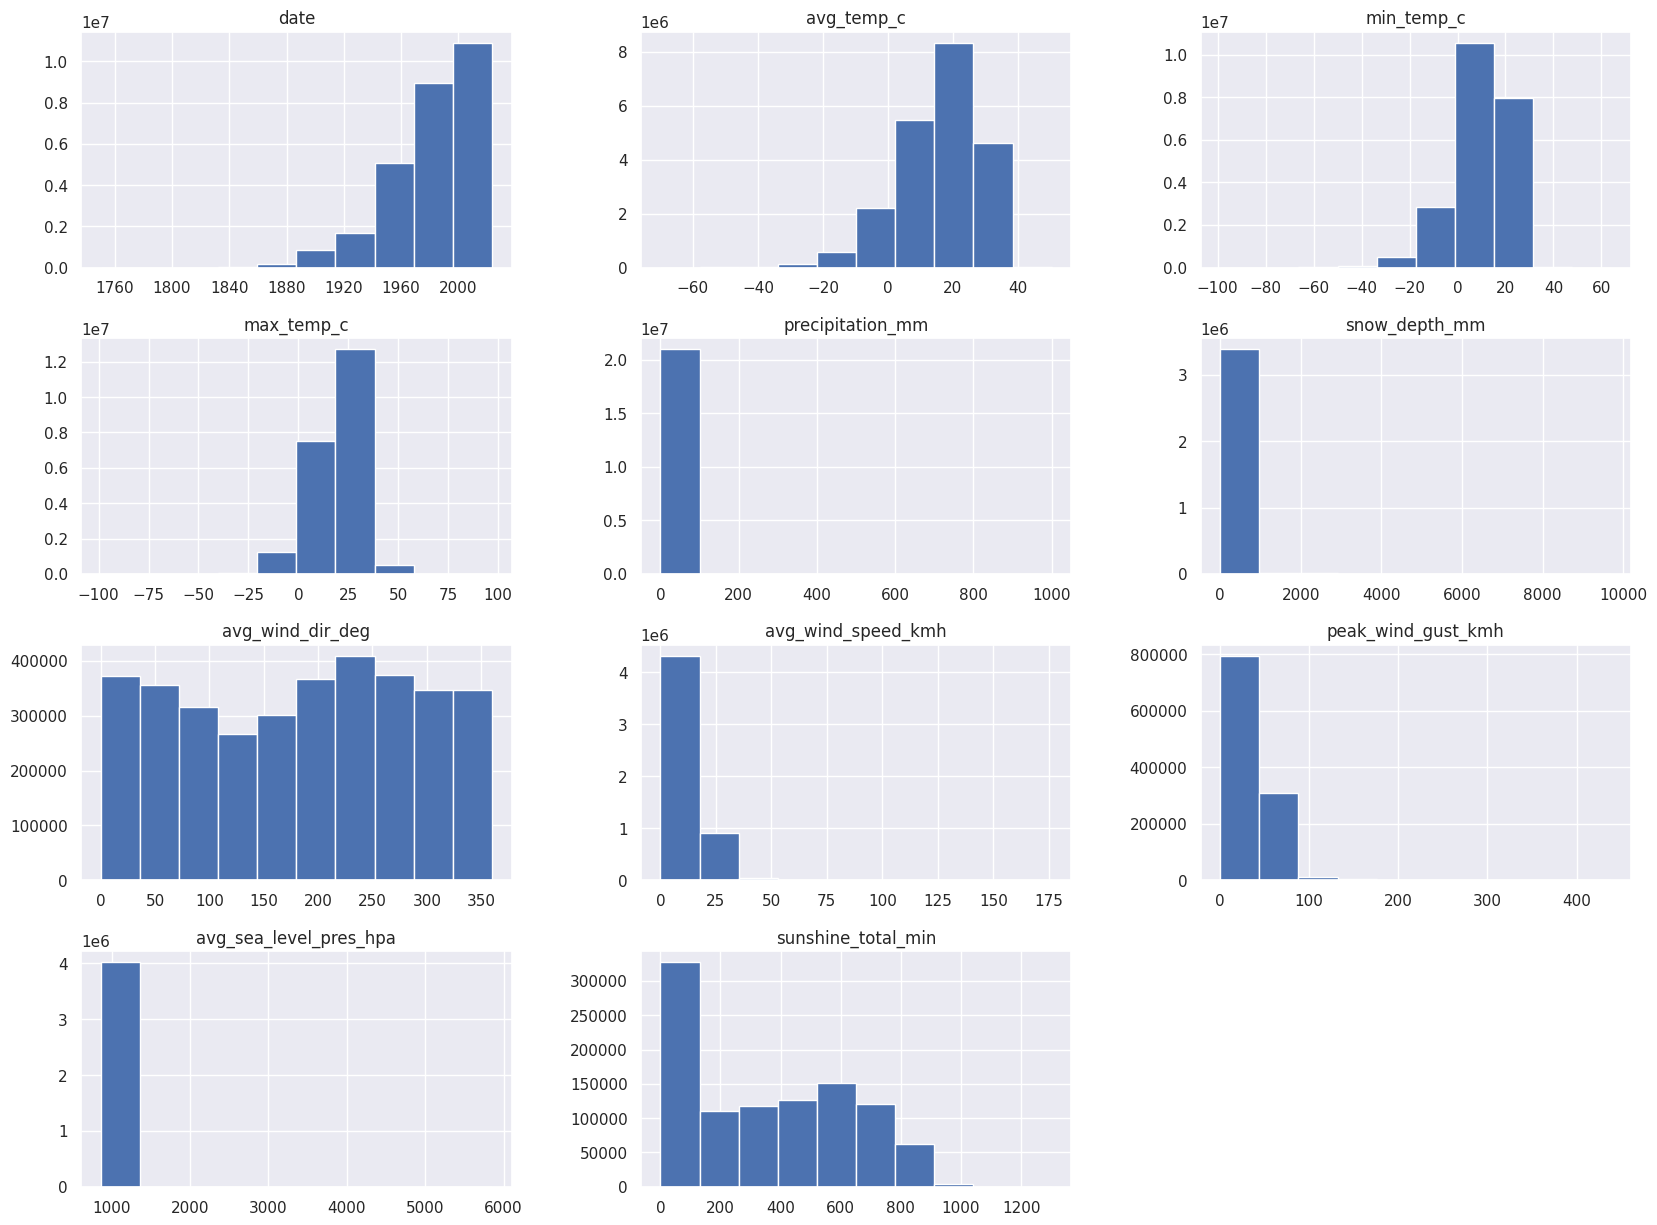

In [29]:
# display histograms
gbl_weather_data.hist(figsize=(20,15))
plt.show()

## Filter Weather data to decrease amount of rows read and speed things up

<blockquote> Based on the histogram above let's narrow down the timeframe for the date column</blockquote> 

In [30]:
# display timeframe of the weather data
gbl_weather_data['date']

0       1957-07-01
1       1957-07-02
2       1957-07-03
3       1957-07-04
4       1957-07-05
           ...    
24216   2023-09-01
24217   2023-09-02
24218   2023-09-03
24219   2023-09-04
24220   2023-09-05
Name: date, Length: 27635763, dtype: datetime64[ns]

In [33]:
# display rows and columns
gbl_weather_data.shape

(27635763, 14)

In [42]:
# calculating Min and Max DateTimes to review timeframe range
print(f"min date: {gbl_weather_data['date'].min()}")
print(f"max date: {gbl_weather_data['date'].max()}")

min date: 1750-02-01 00:00:00
max date: 2023-09-05 00:00:00


## Filter Global Weather By Date

<blockquote> From the histogram above it seems more of the data was captured after 1960's (70's and 80's)
Randomly selected an 80's - 1982 start date and 12-31-2022 end date (for full yearly data capture) and to lessen the amount rows in the dataframe.</blockquote> 

In [19]:
# Filter dates following a date range from histogram 
gweather_subset_date = \
   gbl_weather_data[(gbl_weather_data['date'] >= '1982-01-01 00:00:00') & (gbl_weather_data['date'] < '2023-01-01 00:00:00')]

In [20]:
# display rows and columns after filter
gweather_subset_date.shape

(15641531, 14)

## Drop Rows with Null values - Global Weather data

<blockquote> The global weather dataset at this point is still too large - by dropping rows with missing values will help decrease the amount of rows in the dataset. In order to later merge with the gbl_cities_data_mod to do some filtering by country.</blockquote> 

In [18]:
# display columns with null values
print("\n---Weather data---")
print(gweather_subset_date.isnull().sum())


---Weather data---
station_id                       0
city_name                    13753
date                             0
season                           0
avg_temp_c                  719972
min_temp_c                 2883808
max_temp_c                 2481795
precipitation_mm           4849446
snow_depth_mm             13674550
avg_wind_dir_deg          12922471
avg_wind_speed_kmh        11295169
peak_wind_gust_kmh        14901403
avg_sea_level_pres_hpa    12586414
sunshine_total_min        15074844
dtype: int64


In [21]:
# Drop rows with NaN values in specific columns
gweather_subset_date.dropna(subset=['avg_temp_c','min_temp_c','max_temp_c','precipitation_mm','snow_depth_mm','avg_wind_dir_deg','avg_wind_speed_kmh','peak_wind_gust_kmh','avg_sea_level_pres_hpa','sunshine_total_min'],inplace=True)

In [25]:
# display columns with null values
print("\n---Weather data---")
print(gweather_subset_date.isnull().sum())


---Weather data---
station_id                0
city_name                 0
date                      0
season                    0
avg_temp_c                0
min_temp_c                0
max_temp_c                0
precipitation_mm          0
snow_depth_mm             0
avg_wind_dir_deg          0
avg_wind_speed_kmh        0
peak_wind_gust_kmh        0
avg_sea_level_pres_hpa    0
sunshine_total_min        0
dtype: int64


In [19]:
# review columns that include missing values from the different dataframes
print("Columns with missing values: ")
print(gweather_subset_date.columns[gweather_subset_date.isnull().any()].tolist())

Columns with missing values: 
[]


In [22]:
# display rows and columns after dropping NaN values
gweather_subset_date.shape

(284900, 14)

<h2>US Weather Event data</h2>

<blockquote> Review US Weather Event data, drop columns not necessarily needed for time series analysis.</blockquote> 

In [27]:
# display amount of rows, columns and column names
print(f"\n Rows and columns: {us_event_data.shape}")
print(us_event_data.columns)


 Rows and columns: (8627181, 9)
Index(['EventId', 'weather_event', 'Severity', 'StartTime(UTC)',
       'EndTime(UTC)', 'Precipitation(in)', 'LocationLat', 'LocationLng',
       'State'],
      dtype='object')


## US Weather Event data - Drop columns

In [41]:
# display amount of rows, columns
us_event_data.shape

(8627181, 14)

In [26]:
# display column names
us_event_data.columns

Index(['EventId', 'Type', 'Severity', 'StartTime(UTC)', 'EndTime(UTC)',
       'Precipitation(in)', 'TimeZone', 'AirportCode', 'LocationLat',
       'LocationLng', 'City', 'County', 'State', 'ZipCode'],
      dtype='object')

<blockquote> Dropping columns - granuality would be a state level not timezone, county, city, zipcode level</blockquote> 

In [23]:
# Drop columns and display remaining column names
us_event_data.drop(["TimeZone", "AirportCode", "City", "County", "ZipCode"], axis=1, inplace=True)
us_event_data.columns

Index(['EventId', 'Type', 'Severity', 'StartTime(UTC)', 'EndTime(UTC)',
       'Precipitation(in)', 'LocationLat', 'LocationLng', 'State'],
      dtype='object')

<blockquote> Review data and counts for US Event data</blockquote> 

In [24]:
# display columns with null values
print("\n---US Weather Events data---")
print(us_event_data.isnull().sum())


---US Weather Events data---
EventId              0
Type                 0
Severity             0
StartTime(UTC)       0
EndTime(UTC)         0
Precipitation(in)    0
LocationLat          0
LocationLng          0
State                0
dtype: int64


In [29]:
# review unique values for the Type column
print(us_event_data['Type'].unique())

In [25]:
# Rename Type to a more descriptive name
us_event_data.rename(columns = {"Type":'weather_event'}, inplace = True)

In [28]:
# return the frequency of each distinct row in the Dataframe for specified column
us_event_data["weather_event"].value_counts()

weather_event
Rain             5000794
Fog              2014190
Snow             1158575
Cold              232192
Precipitation     157186
Storm              61317
Hail                2927
Name: count, dtype: int64

In [30]:
# return the frequency of each distinct row in the Dataframe for specified column
us_event_data["Severity"].value_counts()

Severity
Light       5149786
Severe      1729016
Moderate    1369115
Heavy        219151
UNK          157186
Other          2927
Name: count, dtype: int64

## US Weather Event data Filter by columns

<blockquote> Remove rows for unknown and other severity type since there is the data isn't very descriptive</blockquote> 

In [31]:
# Filter Severity events that are Unknown or Other
w_events = ['UNK', 'Other']
us_event_data_filtered = us_event_data[us_event_data.Severity.isin(w_events) == False]

In [32]:
# review unique values for specified column
print(us_event_data_filtered['Severity'].unique())

['Light' 'Severe' 'Moderate' 'Heavy']


<blockquote> review time range for start/end date</blockquote> 

In [52]:
# calculating Start Min and Max DateTimes to review timeframe range
print(f"Start min date: {us_event_data_filtered['StartTime(UTC)'].min()}")
print(f"Start max date: {us_event_data_filtered['StartTime(UTC)'].max()}")

Start min date: 2016-01-01 05:00:00
Start max date: 2022-12-31 23:55:00


In [53]:
# calculating End Min and Max DateTimes to review timeframe range
print(f"End min date: {us_event_data_filtered['EndTime(UTC)'].min()}")
print(f"End max date: {us_event_data_filtered['EndTime(UTC)'].max()}")

End min date: 2016-01-01 05:15:00
End max date: 2023-01-01 00:00:00


In [35]:
us_event_data_filtered.describe(include="all")

EventId weather_event Severity       StartTime(UTC)  \
count   8467068       8467068  8467068              8467068   
unique  8467068             5        4              2262803   
top         W-1          Rain    Light  2017-03-12 06:15:00   
freq          1       5000794  5149786                  116   
mean        NaN           NaN      NaN                  NaN   
std         NaN           NaN      NaN                  NaN   
min         NaN           NaN      NaN                  NaN   
25%         NaN           NaN      NaN                  NaN   
50%         NaN           NaN      NaN                  NaN   
75%         NaN           NaN      NaN                  NaN   
max         NaN           NaN      NaN                  NaN   

               EndTime(UTC)  Precipitation(in)   LocationLat   LocationLng  \
count               8467068       8.467068e+06  8.467068e+06  8.467068e+06   
unique              2211270                NaN           NaN           NaN   
top     2016-03-13 06:15:00                NaN           NaN           NaN   
freq                    102                NaN           NaN           NaN   
mean                    NaN       6.816220e-02  3.883143e+01 -9.196761e+01   
std                     NaN       2.815841e-01  5.460921e+00  1.356109e+01   
min                     NaN       0.000000e+00  2.455710e+01 -1.245550e+02   
25%                     NaN       0.000000e+00  3.464390e+01 -9.790530e+01   
50%                     NaN       0.000000e+00  3.941770e+01 -8.980960e+01   
75%                     NaN       4.000000e-02  4.307960e+01 -8.194720e+01   
max                     NaN       8.769000e+01  4.894020e+01 -6.779280e+01   

          State  
count   8467068  
unique       48  
top          TX  
freq     565558  
mean        NaN  
std         NaN  
min         NaN  
25%         NaN  
50%         NaN  
75%         NaN  
max         NaN

## US Weather data Filter by DateTime 

<blockquote> Randomly selected 2020's to filter the data to minimize row count</blockquote> 

In [36]:
# Filtering data to only the 2020's to reduce the amount of rows
us_event_data_filtered_date = \
   us_event_data_filtered[(us_event_data_filtered['StartTime(UTC)'] >= '2020-01-01 00:00:00') & (us_event_data_filtered['EndTime(UTC)'] < '2023-01-01 00:00:00')]

In [37]:
# display filtered dataframe to reduce amount of rows
us_event_data_filtered_date.shape

(3476892, 9)

In [38]:
# display datatypes
us_event_data_filtered_date.dtypes

EventId               object
weather_event         object
Severity              object
StartTime(UTC)        object
EndTime(UTC)          object
Precipitation(in)    float64
LocationLat          float64
LocationLng          float64
State                 object
dtype: object

<blockquote> Display categorical features that have less than 100 unique values. StartTime and EndTime have many more unique values therefore are not included below. After converting to datetime include histogram? to review distribution?</blockquote>

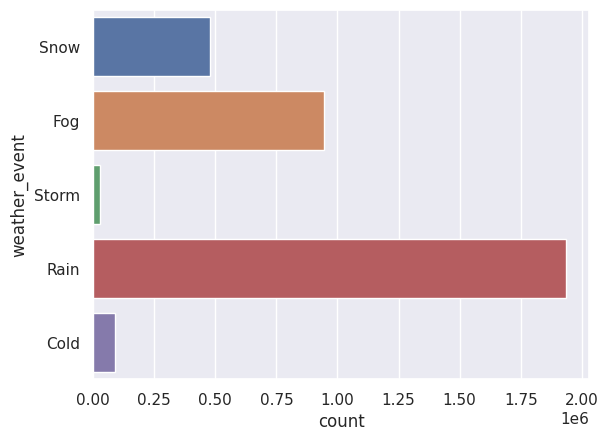

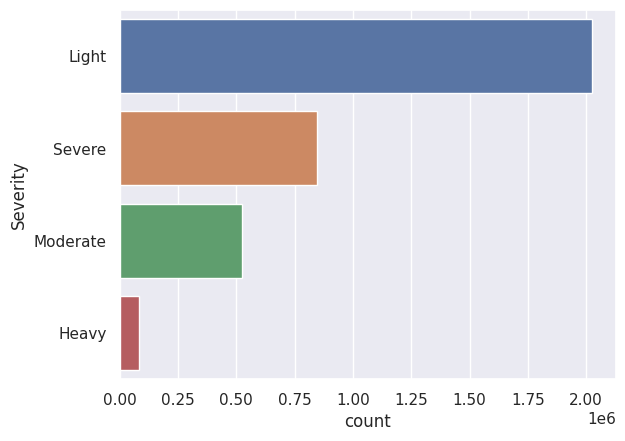

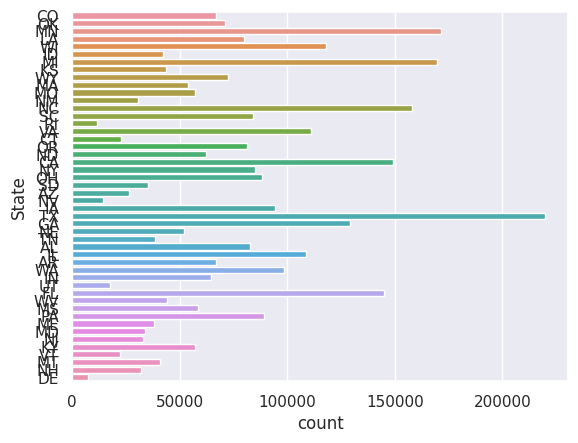

In [57]:
# add visual for object data
for column in us_event_data_filtered_date.select_dtypes(include='object'):
    if us_event_data_filtered_date[column].nunique() < 100:
        sns.countplot(y=column, data=us_event_data_filtered_date)
        plt.show()

<blockquote>Display individual counts for the chart above</blockquote>

In [37]:
print(us_event_data_filtered_date["State"].value_counts())

State
TX    219607
MN    171408
MI    169567
NC    157994
CA    149263
FL    144917
GA    129284
WI    117919
VA    110894
IL    108690
WA     98502
IA     94372
PA     89145
OH     88361
NY     85049
SC     84038
AL     82662
OR     81167
LA     79765
WY     72359
OK     70977
CO     66787
AR     66601
IN     64624
ND     62067
MS     58370
KY     57235
MO     56861
MA     53594
NE     51793
WV     44148
KS     43587
ID     42277
MT     40779
TN     38391
ME     37777
SD     35281
MD     33909
NJ     32987
NH     31929
NM     30779
AZ     26219
CT     22522
VT     22197
UT     17554
NV     14147
RI     11361
DE      7176
Name: count, dtype: int64


<blockquote>Filtered states to match states included in cities data. 
    
Previously was thinking of filtering data according data above for to filter out states with value counts less than 50,000.    
<code>
st_cnt_lt_50k =  ['WV', 'KS', 'ID', 'MT', 'TN', 'ME', 'SD', 'MD', 'NJ', 'NH', 'NM', 'AZ', 'CT', 'VT', 'UT', 'NV', 'RI', 'DE'] 
us_event_st_filtered_date =       
    us_event_st_filtered_date[us_event_st_filtered_date.State.isin(st_cnt_lt_50k) == False]    
</code>   
-- us_event_data_filtered_date
    
['WV', 'KS', 'ID', 'MT', 'TN', 'OK', 'MD', 'NJ', 'NH', 'NM', 'AZ', 'CT', 'UT', 'NV', 'RI',  'CO', 'MN', 'WI', 'MI', 'WY', 'MA', 'MO', 'NC', 'SC', 'VA', 'ND',  'NY', 'OH', 'IA', 'GA', 'NE', 'AL', 'IL', 'IN']  

--  cities_weather (noted in cells in later in the notebook)
    
 'West Virginia', 'Kansas', 'Idaho', 'Montana', 'Tennessee', 'Oklahoma', 'Maryland','New Jersey ,'New Hampshire',
 'New Mexico', 'Arizona', 'Connecticut', 'Utah', 'Nevada', 'Rhode Island',
 'Colorado', 'Minnesota', 'Wisconsin', 'Michigan', 'Wyoming', 'Massachusetts', 'Missouri', 'North Carolina',  'South Carolina', 'Virginia', 'North Dakota',
 'New York', 'Ohio', 'Iowa', 'Georgia', 'Nebraska', 'Alabama', 'Illinois', 'Indiana'

To merge all datasets would need to rename cities_weather US States from full name to 2 letter equivalent.
</blockquote>    

In [39]:
# Filter States to include states are not included in the global weather dataset
st_miss_fm_cit_weather = ['ME', 'SD', 'VT', 'DE', 'LA', 'CA', 'TX', 'AR', 'WA', 'FL', 'MS', 'PA', 'KY', 'OR']
us_event_st_filtered_date = us_event_data_filtered_date[us_event_data_filtered_date.State.isin(st_miss_fm_cit_weather) == True]


## US Event Wether data Convert datetime

<blockquote>Convert datatype to datetime to work on timeseries analysis</blockquote>

In [40]:
# Convert datetime from a string to datetime64
us_event_st_filtered_date['StartTime(UTC)'] = pd.to_datetime(us_event_data_filtered_date['StartTime(UTC)'])
us_event_st_filtered_date['EndTime(UTC)'] = pd.to_datetime(us_event_data_filtered_date['EndTime(UTC)'])

In [41]:
us_event_st_filtered_date.dtypes

EventId                      object
Type                         object
Severity                     object
StartTime(UTC)       datetime64[ns]
EndTime(UTC)         datetime64[ns]
Precipitation(in)           float64
LocationLat                 float64
LocationLng                 float64
State                        object
dtype: object

<blockquote>Rename columns to reflect only date portion and convert datatype for new columns</blockquote>

In [42]:
# Extract Date from StartDate/EndDate Datetime Column changes datatype back to object
us_event_st_filtered_date['StartDate'] = us_event_st_filtered_date['StartTime(UTC)'].dt.date
us_event_st_filtered_date['EndDate'] = us_event_st_filtered_date['EndTime(UTC)'].dt.date

In [43]:
# Convert datatype
us_event_st_filtered_date['StartDate'] = pd.to_datetime(us_event_st_filtered_date['StartDate'])
us_event_st_filtered_date['EndDate'] = pd.to_datetime(us_event_st_filtered_date['EndDate'])

<blockquote>
Code that can be used to analyze monthly or hourly by extracting month or time.

<h5> To analyze by months the following lines of code can be incorporated (before dropping StartTime(UTC) and EndTime(UTC))</h5>
---
<code>    
us_event_data_filtered_date['StartMonthName'] = us_event_data_filtered_date['StartTime(UTC)'].dt.month_name()
us_event_data_filtered_date['EndMonthName'] = us_event_data_filtered_date['EndTime(UTC)'].dt.month_name()
</code>
---
<h5> To analyze by hours the following lines of code can be incorporated (before dropping StartTime(UTC) and EndTime(UTC))
</h5>
---
<code>    
us_event_data_filtered_date['Time_Start'] = pd.to_datetime(us_event_data_filtered_date['StartTime(UTC)']).dt.time
us_event_data_filtered_date['Time_End'] = pd.to_datetime(us_event_data_filtered_date['EndTime(UTC)']).dt.time

In [44]:
# Drop columns and display remaining column names
us_event_st_filtered_date.drop(["StartTime(UTC)", "EndTime(UTC)"], axis=1, inplace=True)
us_event_st_filtered_date.columns

Index(['EventId', 'weather_event', 'Severity', 'Precipitation(in)',
       'LocationLat', 'LocationLng', 'State', 'StartDate', 'EndDate'],
      dtype='object')

In [49]:
#  display information about a DataFrame
us_event_st_filtered_date.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1147003 entries, 14586 to 8611713
Data columns (total 9 columns):
 #   Column             Non-Null Count    Dtype         
---  ------             --------------    -----         
 0   EventId            1147003 non-null  object        
 1   weather_event      1147003 non-null  object        
 2   Severity           1147003 non-null  object        
 3   Precipitation(in)  1147003 non-null  float64       
 4   LocationLat        1147003 non-null  float64       
 5   LocationLng        1147003 non-null  float64       
 6   State              1147003 non-null  object        
 7   StartDate          1147003 non-null  datetime64[ns]
 8   EndDate            1147003 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(3), object(4)
memory usage: 87.5+ MB


<blockquote> review data to possibly include later to merged cities_global data<blockquote>

In [47]:
# display min, max, mean, standard deviation, variance for Precipitation
print(f"Min Precipitation(in): {us_event_st_filtered_date['Precipitation(in)'].min()}")
print(f"Max Precipitation(in): {us_event_st_filtered_date['Precipitation(in)'].max()}")
print(f"Mean Precipitation(in): {us_event_st_filtered_date['Precipitation(in)'].mean().round(7)}")
print(f"Standard Deviation Precipitation(in): {us_event_st_filtered_date['Precipitation(in)'].std().round(7)}")
print(f"Variance Precipitation(in): {us_event_st_filtered_date['Precipitation(in)'].var().round(7)}")

Min Precipitation(in): 0.0
Max Precipitation(in): 27.63
Mean Precipitation(in): 0.0653655
Standard Deviation Precipitation(in): 0.2612046
Variance Precipitation(in): 0.0682278


In [50]:
# transformed shape for US Weather Events
print(f"filtered by date {us_event_data_filtered_date.shape}")
print(f"filtered by date and state {us_event_st_filtered_date.shape}") 

filtered by date (3476892, 9)
filtered by date and state (1147003, 9)


In [73]:
us_event_data_filtered_date.loc[ \
    (us_event_data_filtered_date['Precipitation(in)'] < (us_event_data_filtered_date['Precipitation(in)'].mean() - 3 * us_event_data_filtered_date['Precipitation(in)'].std())) \
    | (us_event_data_filtered_date['Precipitation(in)'] > (us_event_data_filtered_date['Precipitation(in)'].mean() + 3 * us_event_data_filtered_date['Precipitation(in)'].std())
    )
]

EventId weather_event  Severity       StartTime(UTC)  \
6495        W-6620          Rain     Heavy  2021-07-11 06:56:00   
6528        W-6653          Rain     Heavy  2021-08-13 23:56:00   
10405      W-10662          Rain     Heavy  2020-08-31 10:35:00   
10781      W-11038          Rain  Moderate  2021-04-08 11:55:00   
10782      W-11039          Rain     Heavy  2021-04-08 14:15:00   
...            ...           ...       ...                  ...   
8618905  W-9083284          Rain     Heavy  2022-10-25 20:44:00   
8618907  W-9083286          Rain  Moderate  2022-10-25 21:31:00   
8618960  W-9083339          Rain     Heavy  2022-11-27 04:34:00   
8620947  W-9085514          Rain  Moderate  2021-10-25 05:37:00   
8627000  W-9091714          Rain     Light  2022-05-30 16:25:00   

                EndTime(UTC)  Precipitation(in)  LocationLat  LocationLng  \
6495     2021-07-11 07:12:00               1.70      34.6986     -99.3381   
6528     2021-08-14 00:26:00               1.07      34.6986     -99.3381   
10405    2020-08-31 10:55:00               0.93      43.6822     -93.3722   
10781    2021-04-08 14:15:00               1.46      43.6822     -93.3722   
10782    2021-04-08 16:55:00               2.80      43.6822     -93.3722   
...                      ...                ...          ...          ...   
8618905  2022-10-25 21:04:00               0.97      37.9740     -92.6910   
8618907  2022-10-25 23:24:00               1.40      37.9740     -92.6910   
8618960  2022-11-27 05:03:00               1.28      37.9740     -92.6910   
8620947  2021-10-25 07:47:00               0.87      40.6000    -116.8667   
8627000  2022-06-01 00:53:00               1.71      42.5833    -108.2833   

        State  
6495       OK  
6528       OK  
10405      MN  
10781      MN  
10782      MN  
...       ...  
8618905    MO  
8618907    MO  
8618960    MO  
8620947    NV  
8627000    WY  

[33962 rows x 9 columns]

Geo Data


<blockquote>Since currently not using the US event data - I was going to add either geopandas or other lib code to view/visualize the location data</blockquote>

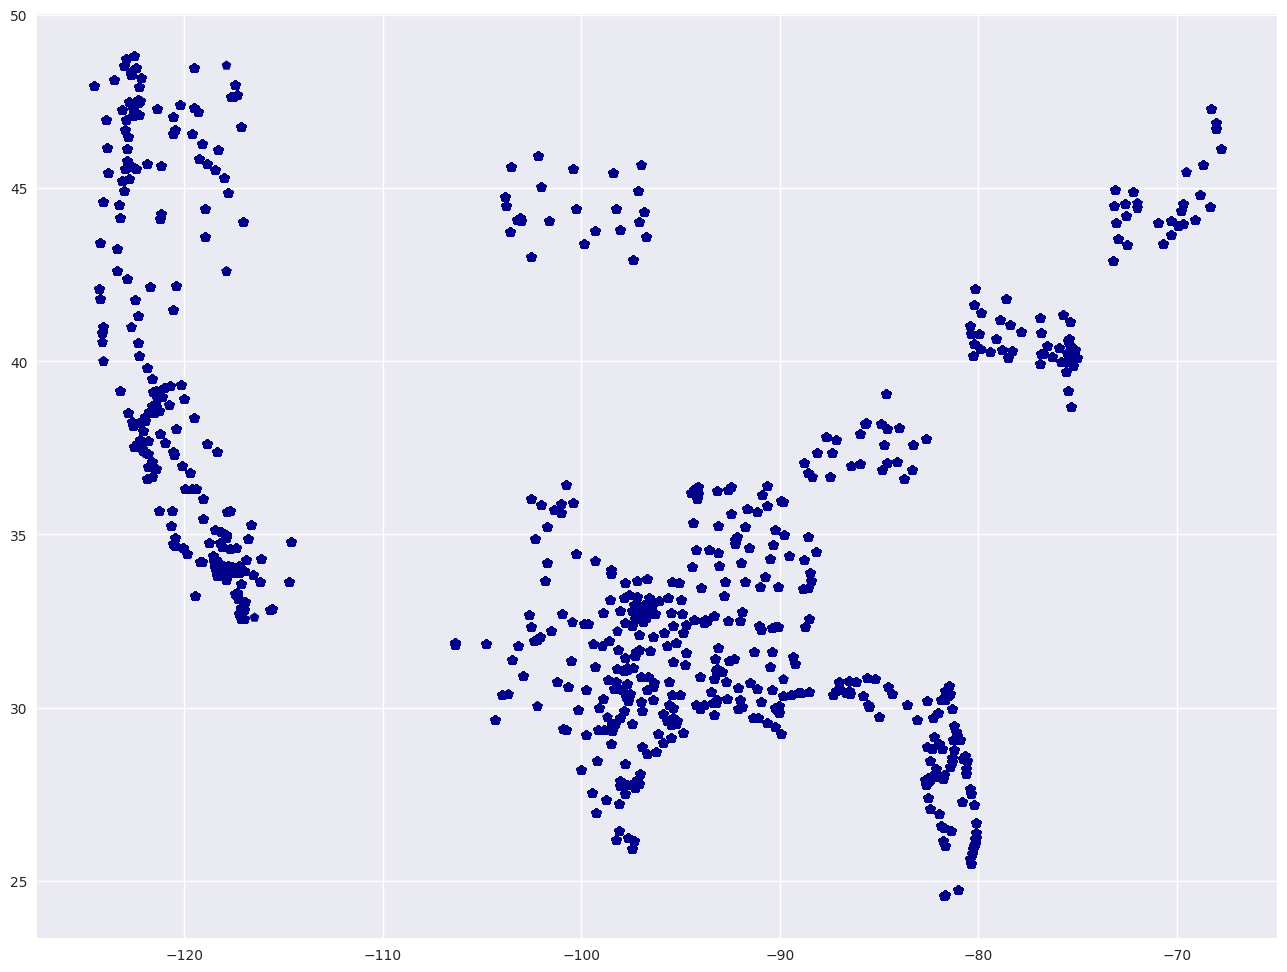

In [103]:
plt.scatter(x=us_event_st_filtered_date.LocationLng,y=us_event_st_filtered_date.LocationLat, c = 'darkblue', marker = 'p')
plt.show();

In [ ]:
# Convert the pandas DataFrame into a geo-DataFrame requires latitude and longitude to be converted into Points
#df = us_event_st_filtered_date
#df_geo = gpd.GeoDataFrame(df, geometry = gpd.points_from_xy(df.LocationLat, df.LocationLng), crs="EPSG:4326")

# display geopandas dataframe
#df_geo.head(3)

##  Merge dataframes - Global Cities and Global Weather data 

<blockquote>Merged the datasets in order to connect the cities data with the weather data and perform the time series analysis. Before merging review datatypes, columns, and shape.</blockquote>

In [51]:
# display information about a DataFrame
gweather_subset_date.info()

<class 'pandas.core.frame.DataFrame'>
Index: 284900 entries, 6266 to 22432
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   station_id              284900 non-null  category      
 1   city_name               284900 non-null  category      
 2   date                    284900 non-null  datetime64[ns]
 3   season                  284900 non-null  category      
 4   avg_temp_c              284900 non-null  float64       
 5   min_temp_c              284900 non-null  float64       
 6   max_temp_c              284900 non-null  float64       
 7   precipitation_mm        284900 non-null  float64       
 8   snow_depth_mm           284900 non-null  float64       
 9   avg_wind_dir_deg        284900 non-null  float64       
 10  avg_wind_speed_kmh      284900 non-null  float64       
 11  peak_wind_gust_kmh      284900 non-null  float64       
 12  avg_sea_level_pres_hpa  284900 no

In [52]:
# display information about a DataFrame
gbl_cities_data_mod.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1238 entries, 0 to 1244
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   station_id  1238 non-null   object 
 1   city_name   1237 non-null   object 
 2   country     1238 non-null   object 
 3   state       1211 non-null   object 
 4   iso3        1238 non-null   object 
 5   latitude    1238 non-null   float64
 6   longitude   1238 non-null   float64
dtypes: float64(2), object(5)
memory usage: 77.4+ KB


In [53]:
# display column names
print(f"global weather data\n{gweather_subset_date.columns}")
print(f"\nglobal cities data\n{gbl_cities_data_mod.columns}")

global weather data
Index(['station_id', 'city_name', 'date', 'season', 'avg_temp_c', 'min_temp_c',
       'max_temp_c', 'precipitation_mm', 'snow_depth_mm', 'avg_wind_dir_deg',
       'avg_wind_speed_kmh', 'peak_wind_gust_kmh', 'avg_sea_level_pres_hpa',
       'sunshine_total_min'],
      dtype='object')

global cities data
Index(['station_id', 'city_name', 'country', 'state', 'iso3', 'latitude',
       'longitude'],
      dtype='object')


In [54]:
# display dataframes before merge
print(gweather_subset_date.shape)
print(gbl_cities_data_mod.shape)

(284900, 14)
(1238, 7)


## Merge dataframes to a new cities_weather dataframe

<blockquote>Merge the datasets on station_id since both datasets have that column in common. 
Merging in order to analyze the global weather data - global weather data does not include the country data which is needed to observe country weather changes over the years.
</blockquote>

In [55]:
# Merge dataframe
cities_weather = pd.merge(gweather_subset_date, gbl_cities_data_mod,left_on='station_id',right_on='station_id',how='inner')

In [56]:
# display merged rows and columns
cities_weather.shape

(295912, 20)

In [57]:
# display datatypes
cities_weather.dtypes

station_id                        object
city_name_x                     category
date                      datetime64[ns]
season                          category
avg_temp_c                       float64
min_temp_c                       float64
max_temp_c                       float64
precipitation_mm                 float64
snow_depth_mm                    float64
avg_wind_dir_deg                 float64
avg_wind_speed_kmh               float64
peak_wind_gust_kmh               float64
avg_sea_level_pres_hpa           float64
sunshine_total_min               float64
city_name_y                       object
country                           object
state                             object
iso3                              object
latitude                         float64
longitude                        float64
dtype: object

<blockquote>Reviewing state in the merged dataset and different features
state - to compare with the US Weather Event data states column
seasons - to see if any NaNs or Unknowns are included in rows
    
Drop any NaNs for the specified columns
</blockquote> 

In [58]:
# display unique states
print(cities_weather['state'].unique())

[nan 'Unknown' 'Sjaælland' 'Berlin' 'Bremen' 'Nordrhein-Westfalen'
 'Thüringen' 'Hamburg' 'Niedersachsen' 'Schleswig-Holstein'
 'Sachsen-Anhalt' 'Bayern' 'Brandenburg' 'Mecklenburg-Vorpommern'
 'Baden-Württemberg' 'Skåne' 'Thurgau' 'New York' 'Maryland' 'Georgia'
 'North Dakota' 'Idaho' 'Massachusetts' 'Nevada' 'West Virginia' 'Wyoming'
 'South Carolina' 'Ohio' 'New Hampshire' 'Colorado' 'Iowa' 'Connecticut'
 'Montana' 'Hawaii' 'Indiana' 'Missouri' 'Michigan' 'Nebraska' 'Wisconsin'
 'Alabama' 'Tennessee' 'Oklahoma' 'Arizona' 'Rhode Island'
 'North Carolina' 'Virginia' 'Minnesota' 'Utah' 'New Mexico' 'Illinois'
 'Kansas' 'New Jersey' 'District of Columbia']


<blockquote>Filter out Unknown values for states and drop NaN values</blockquote>

In [59]:
# Filter Severity events that are Moderate, Unknown or Other
state_unk = ['Unknown']
cities_weather = cities_weather[cities_weather.state.isin(state_unk) == False]

In [60]:
# Drop rows with NaN values in specific columns
cities_weather.dropna(subset=['avg_temp_c','min_temp_c','max_temp_c','precipitation_mm','snow_depth_mm','avg_wind_dir_deg','avg_wind_speed_kmh',\
                                    'peak_wind_gust_kmh','avg_sea_level_pres_hpa','sunshine_total_min','state'],inplace=True)

In [28]:
# diplay column names
cities_weather.columns

Index(['station_id', 'city_name_x', 'date', 'season', 'avg_temp_c',
       'min_temp_c', 'max_temp_c', 'precipitation_mm', 'snow_depth_mm',
       'avg_wind_dir_deg', 'avg_wind_speed_kmh', 'peak_wind_gust_kmh',
       'avg_sea_level_pres_hpa', 'sunshine_total_min', 'city_name_y',
       'country', 'state', 'iso3', 'latitude', 'longitude'],
      dtype='object')

In [29]:
# display columns with null values
print("\n---Weather data---")
print(cities_weather.isnull().sum())


---Weather data---
station_id                0
city_name_x               0
date                      0
season                    0
avg_temp_c                0
min_temp_c                0
max_temp_c                0
precipitation_mm          0
snow_depth_mm             0
avg_wind_dir_deg          0
avg_wind_speed_kmh        0
peak_wind_gust_kmh        0
avg_sea_level_pres_hpa    0
sunshine_total_min        0
city_name_y               0
country                   0
state                     0
iso3                      0
latitude                  0
longitude                 0
dtype: int64


In [46]:
# display unique seasons
print(cities_weather['season'].unique())

['Summer', 'Autumn', 'Winter', 'Spring']
Categories (4, object): ['Autumn', 'Spring', 'Summer', 'Winter']


<blockquote> Drop duplicate city_name created when dataframes were merged. Also remove iso3 (3 letter representation of country), station_id, and state, since analysis will analysis will be done by countries.</blockquote>

In [61]:
# Drop extra city_name column city_name_y created when dataframes were merged & other cols
cities_weather.drop(["city_name_x", "iso3", "station_id", "state"], axis=1, inplace=True)

In [62]:
# Rename city_name_x back to city_name
cities_weather.rename(columns = {"city_name_y":'city_name'}, inplace = True)

In [64]:
# display merged dataframe columns
cities_weather.columns

Index(['date', 'season', 'avg_temp_c', 'min_temp_c', 'max_temp_c',
       'precipitation_mm', 'snow_depth_mm', 'avg_wind_dir_deg',
       'avg_wind_speed_kmh', 'peak_wind_gust_kmh', 'avg_sea_level_pres_hpa',
       'sunshine_total_min', 'city_name', 'country', 'latitude', 'longitude'],
      dtype='object')

<blockquote>Visualize average/max temperature and season data
Initially also included violin plots but decided to only keep both plots</blockquote>

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'Denmark'),
  Text(1, 0, 'Germany'),
  Text(2, 0, 'Sweden'),
  Text(3, 0, 'Switzerland'),
  Text(4, 0, 'United States')])

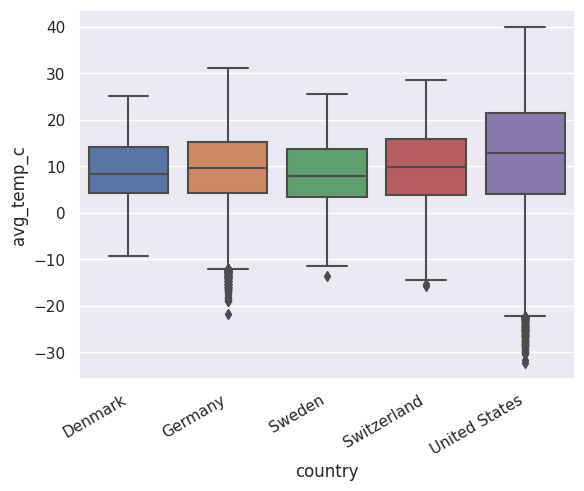

In [63]:
# boxplot countries - average temperature
sns.boxplot(data=cities_weather, x ='country', y ='avg_temp_c')
plt.xticks(rotation=30, ha='right')

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'Denmark'),
  Text(1, 0, 'Germany'),
  Text(2, 0, 'Sweden'),
  Text(3, 0, 'Switzerland'),
  Text(4, 0, 'United States')])

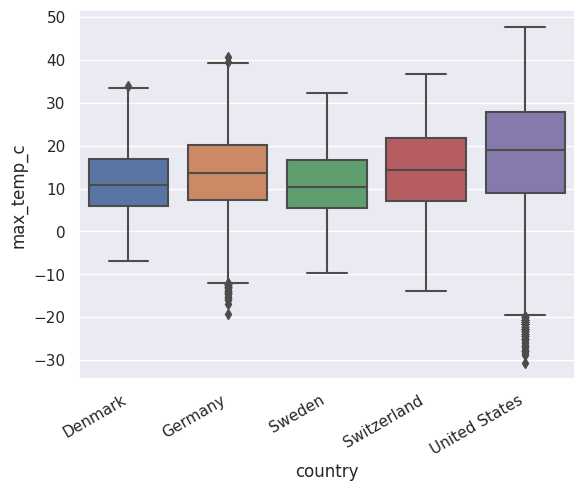

In [64]:
# boxplot countries - max temperature
sns.boxplot(data=cities_weather, x ='country', y ='max_temp_c')
plt.xticks(rotation=30, ha='right')

(array([0, 1, 2, 3]),
 [Text(0, 0, 'Autumn'),
  Text(1, 0, 'Spring'),
  Text(2, 0, 'Summer'),
  Text(3, 0, 'Winter')])

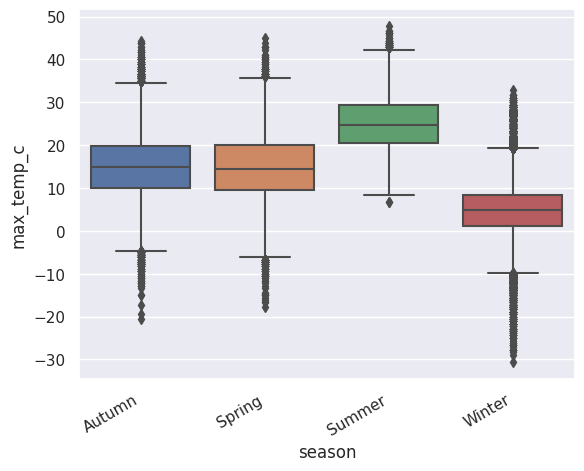

In [65]:
# boxplot seasons - average temperature
sns.boxplot(data=cities_weather, x ='season', y ='max_temp_c')
plt.xticks(rotation=30, ha='right')

### Clip outliers

<blockquote>Based on visuals above - decided to remove extreme outliers and visualize updated data</blockquote>

In [65]:
# Remove extreme outliers shown on boxplots for Max Temp
upper_threshold = 40 # threshold for outliers
lower_threshold = 0

cities_weather['max_temp_c'][(cities_weather['max_temp_c'] > upper_threshold) | (cities_weather['max_temp_c'] < lower_threshold)]

# Clip values to the specified bounds
cities_weather['max_temp_c'] = cities_weather['max_temp_c'].clip(lower=lower_threshold, upper=upper_threshold)

cities_weather.head(3)

date  season  avg_temp_c  min_temp_c  max_temp_c  \
22024 1996-08-01  Summer        18.6        15.6        23.0   
22025 1996-08-02  Summer        17.2        14.9        19.3   
22026 1996-08-03  Summer        16.6        14.7        18.6   

       precipitation_mm  snow_depth_mm  avg_wind_dir_deg  avg_wind_speed_kmh  \
22024               0.0            0.0             219.0                15.1   
22025               0.0            0.0             263.0                24.5   
22026               0.0            0.0             291.0                25.2   

       peak_wind_gust_kmh  avg_sea_level_pres_hpa  sunshine_total_min  \
22024                36.0                  1013.7               270.0   
22025                45.7                  1018.7               588.0   
22026                39.2                  1024.7               618.0   

      city_name  country   latitude  longitude  
22024      Sorø  Denmark  55.432998  11.566702  
22025      Sorø  Denmark  55.432998  11.566702  
22026      Sorø  Denmark  55.432998  11.566702

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'Denmark'),
  Text(1, 0, 'Germany'),
  Text(2, 0, 'Sweden'),
  Text(3, 0, 'Switzerland'),
  Text(4, 0, 'United States')])

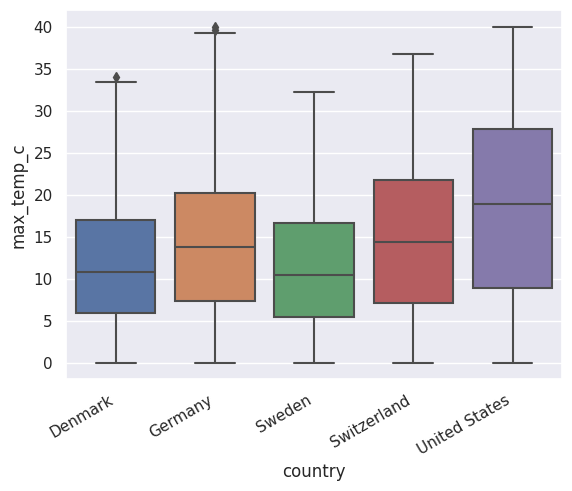

In [66]:
# box plot - max temperature with removing outliers
sns.boxplot(data=cities_weather, x ='country', y ='max_temp_c')
plt.xticks(rotation=30, ha='right')

<blockquote>Initially was going to focus on data for United States but the timeframe for some reason stopped in 1998. In addition to the size the two weather datasets do not seem to overlap - the US Weather Event dataset timeframe is 2016-2022.</blockquote>

In [67]:
# Filter to only analyze United States data
cities_weather_subset = cities_weather[cities_weather['country'] >= 'United States']

In [68]:
# display sample rows of the new filtered dataframe
cities_weather_subset.sample(3)

date  season  avg_temp_c  min_temp_c  max_temp_c  \
222212 1992-09-02  Autumn        19.9        10.0        28.9   
228125 1984-10-11  Autumn        14.7        11.7        16.7   
234050 1988-01-28  Winter        -1.2        -6.7         5.0   

        precipitation_mm  snow_depth_mm  avg_wind_dir_deg  avg_wind_speed_kmh  \
222212               0.0            0.0             252.0                11.5   
228125               0.0            0.0              44.0                 9.7   
234050               0.0            0.0             119.0                17.6   

        peak_wind_gust_kmh  avg_sea_level_pres_hpa  sunshine_total_min  \
222212                37.1                  1013.8               718.0   
228125                20.5                  1028.0                 0.0   
234050                37.1                  1026.8               568.0   

          city_name        country   latitude   longitude  
222212  Carson City  United States  39.163848 -119.766395  
228125     Columbus  United States  39.979974  -82.990010  
234050   Des Moines  United States  41.579980  -93.619981

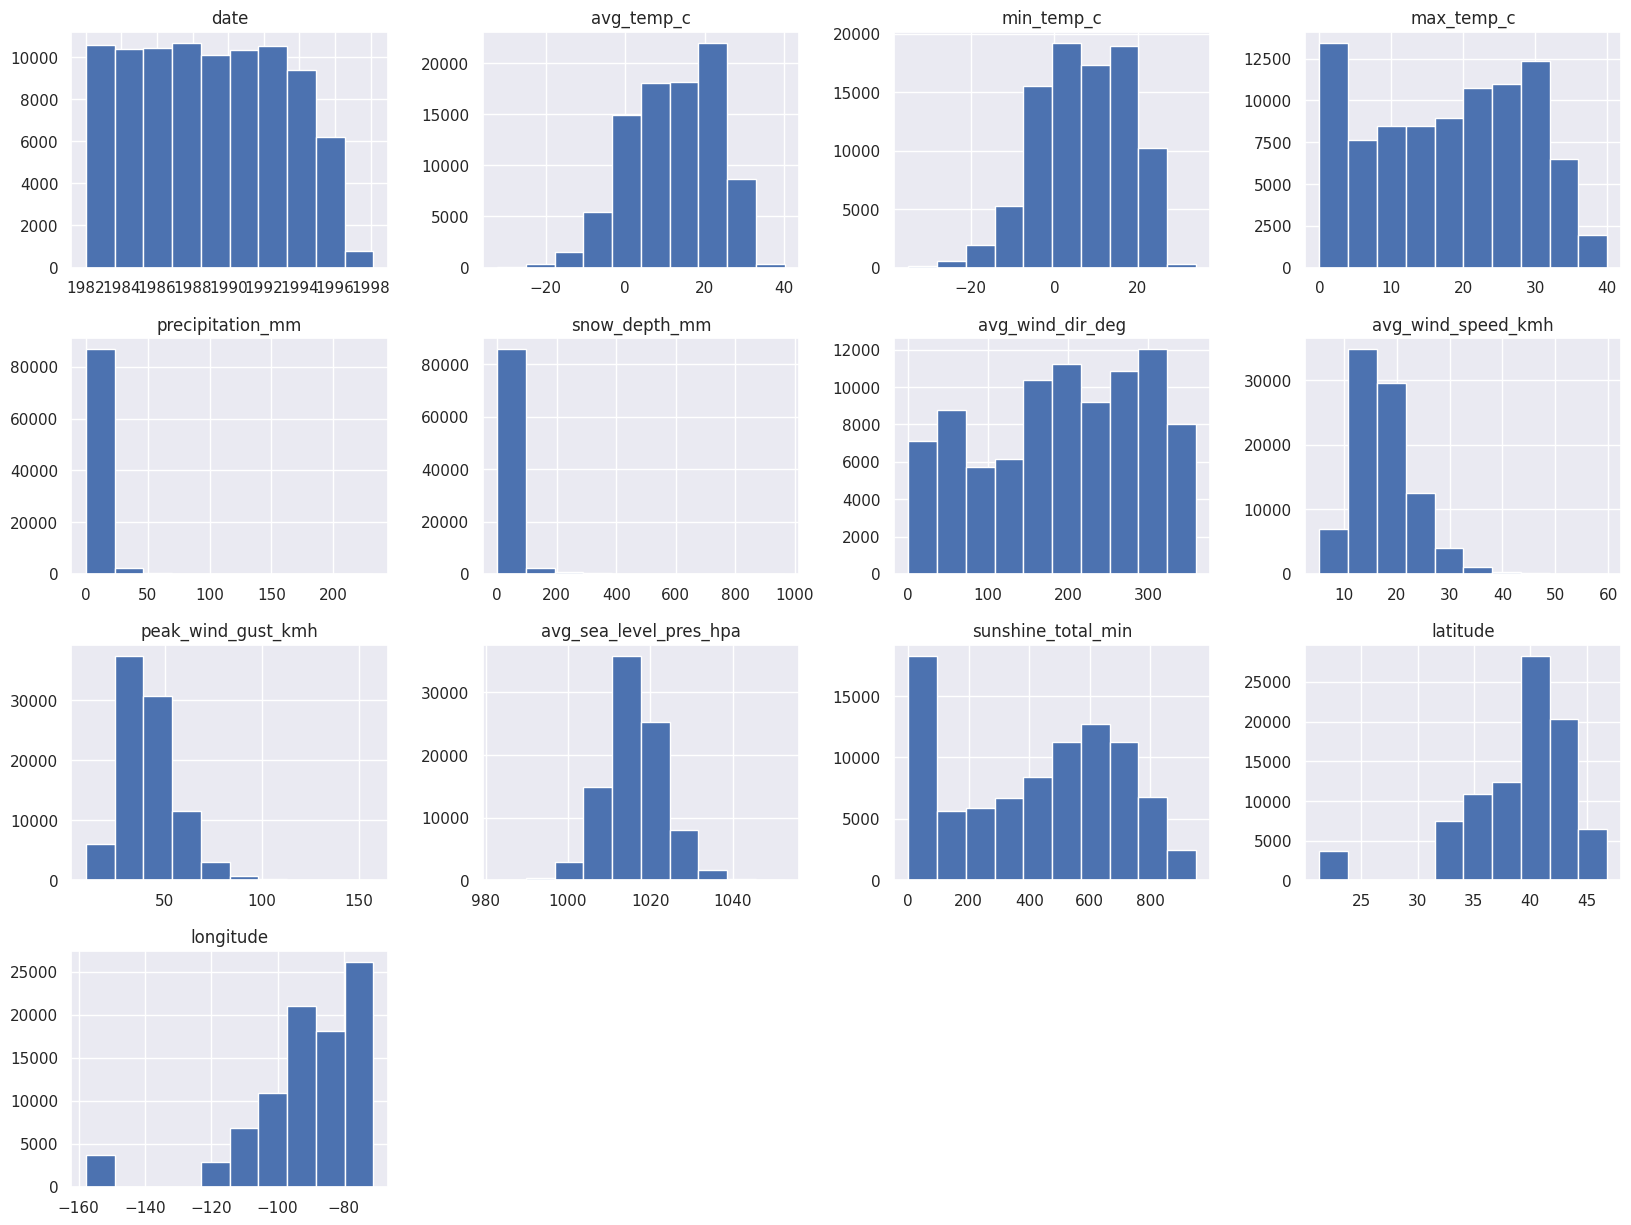

In [69]:
# display histogram for merged US subset dataset
cities_weather_subset.hist(figsize=(20,15))
plt.show()

In [27]:
# summary statistics for United States subset
cities_weather_subset.describe(include='all')

date  season    avg_temp_c    min_temp_c  \
count                           89480   89480  89480.000000  89480.000000   
unique                            NaN       4           NaN           NaN   
top                               NaN  Spring           NaN           NaN   
freq                              NaN   24850           NaN           NaN   
mean    1988-12-13 21:11:22.664282624     NaN     12.190638      6.918709   
min               1982-01-01 00:00:00     NaN    -32.200000    -35.000000   
25%               1985-06-08 00:00:00     NaN      4.000000     -0.600000   
50%               1988-11-25 00:00:00     NaN     12.900000      7.200000   
75%               1992-05-19 00:00:00     NaN     21.500000     15.600000   
max               1998-02-25 00:00:00     NaN     40.100000     33.900000   
std                               NaN     NaN     10.866377     10.668846   

          max_temp_c  precipitation_mm  snow_depth_mm  avg_wind_dir_deg  \
count   89480.000000      89480.000000   89480.000000      89480.000000   
unique           NaN               NaN            NaN               NaN   
top              NaN               NaN            NaN               NaN   
freq             NaN               NaN            NaN               NaN   
mean       17.976016          2.783770      10.332555        192.948502   
min         0.000000          0.000000       0.000000          0.000000   
25%         8.900000          0.000000       0.000000        112.000000   
50%        18.900000          0.000000       0.000000        199.000000   
75%        27.800000          1.000000       0.000000        280.000000   
max        40.000000        232.400000     965.000000        360.000000   
std        10.936798          8.109899      44.867951        100.449786   

        avg_wind_speed_kmh  peak_wind_gust_kmh  avg_sea_level_pres_hpa  \
count         89480.000000        89480.000000            89480.000000   
unique                 NaN                 NaN                     NaN   
top                    NaN                 NaN                     NaN   
freq                   NaN                 NaN                     NaN   
mean             17.619699           42.367645             1016.189053   
min               5.400000            9.400000              982.800000   
25%              13.700000           33.500000             1011.700000   
50%              16.600000           40.700000             1016.000000   
75%              20.900000           50.000000             1020.400000   
max              59.800000          157.300000             1052.600000   
std               5.573524           13.827619                7.146451   

        sunshine_total_min city_name        country      latitude  \
count         89480.000000     89480          89480  89480.000000   
unique                 NaN        36              1           NaN   
top                    NaN    Boston  United States           NaN   
freq                   NaN      4754          89480           NaN   
mean            423.019144       NaN            NaN     39.105636   
min               0.000000       NaN            NaN     21.306876   
25%             164.000000       NaN            NaN     37.550019   
50%             474.000000       NaN            NaN     39.979974   
75%             652.000000       NaN            NaN     41.821102   
max             951.000000       NaN            NaN     46.808317   
std             275.984502       NaN            NaN      4.873757   

           longitude  
count   89480.000000  
unique           NaN  
top              NaN  
freq             NaN  
mean      -91.652388  
min      -157.857998  
25%       -97.518684  
50%       -89.401117  
75%       -77.449986  
max       -71.070014  
std        18.573312

<blockquote>Created scatter plot to review the different numerial features</blockquote>

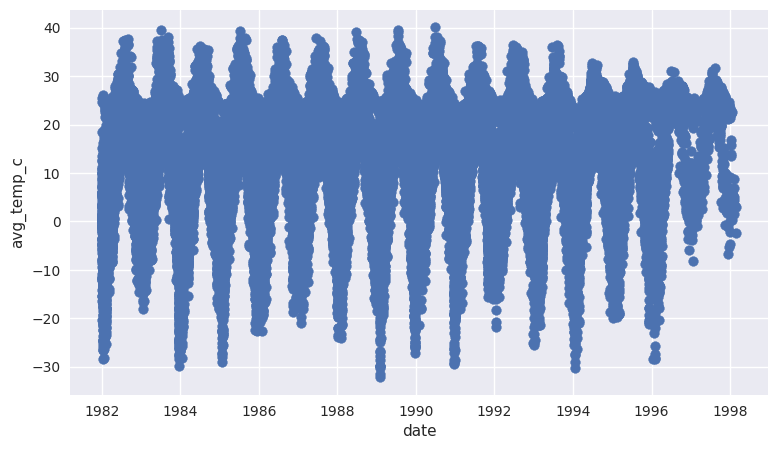

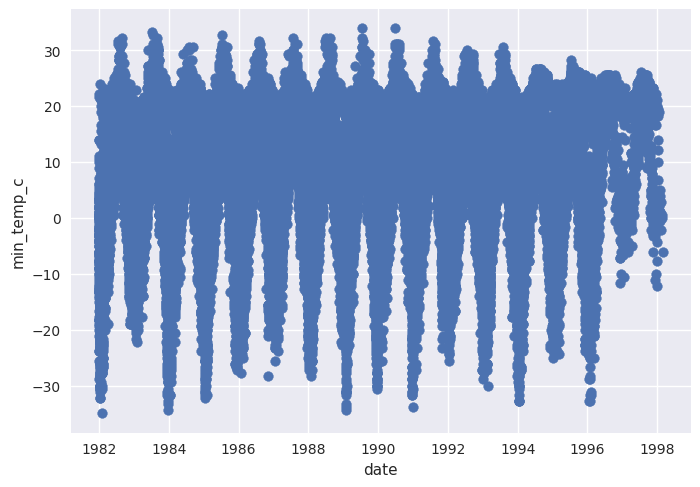

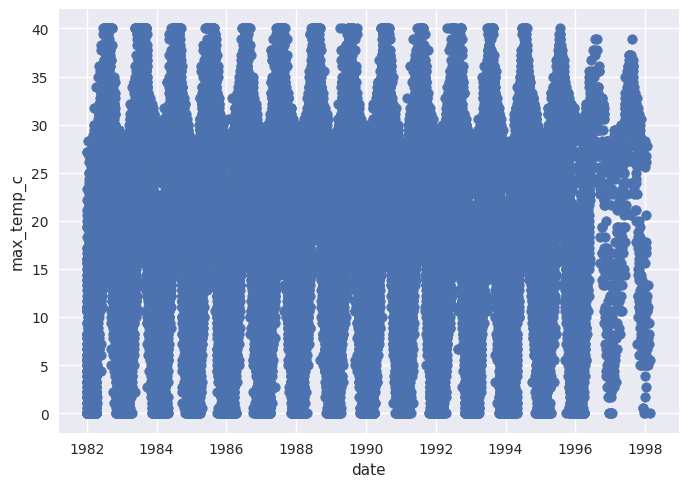

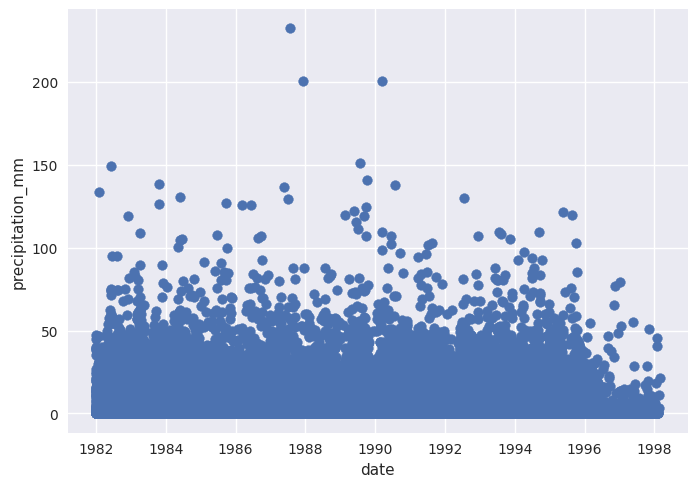

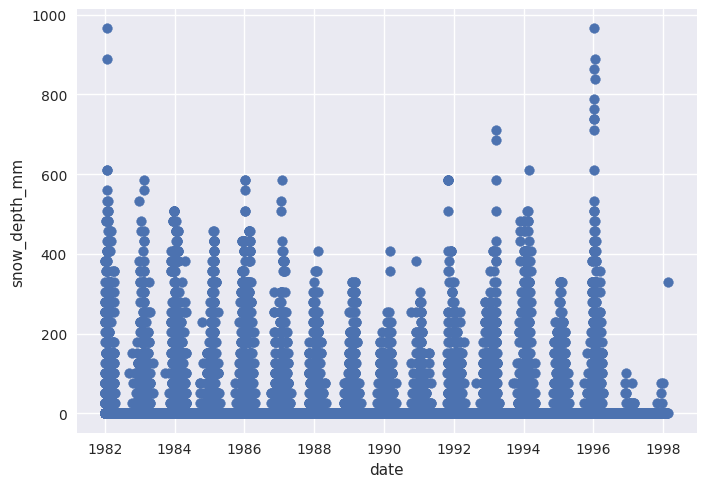

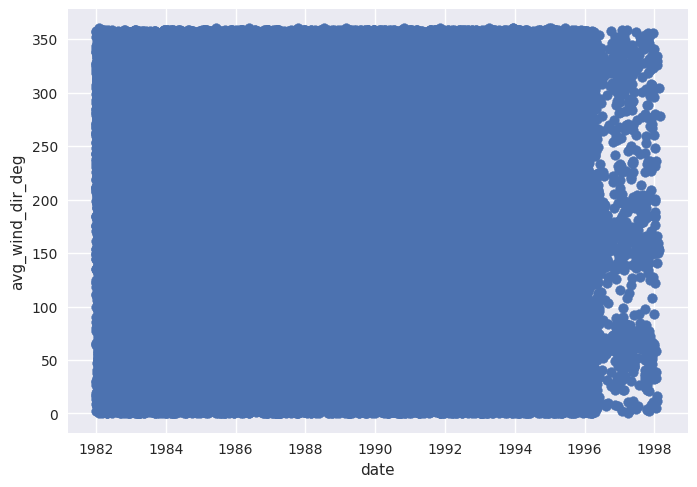

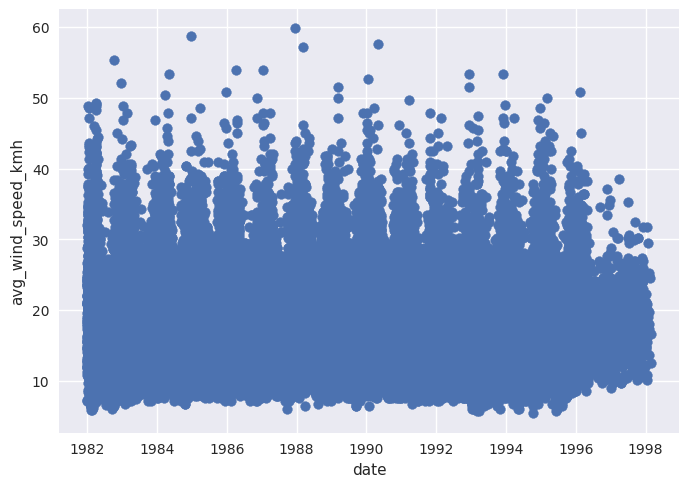

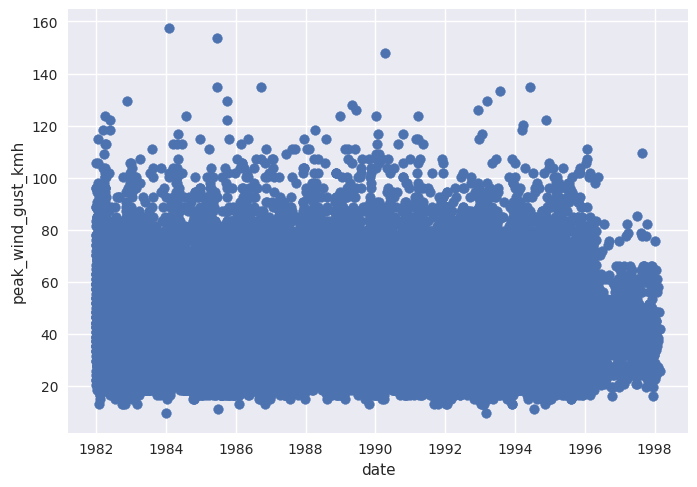

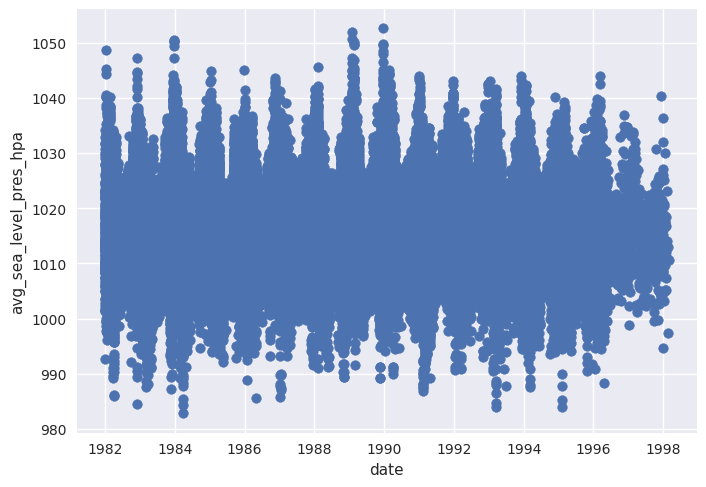

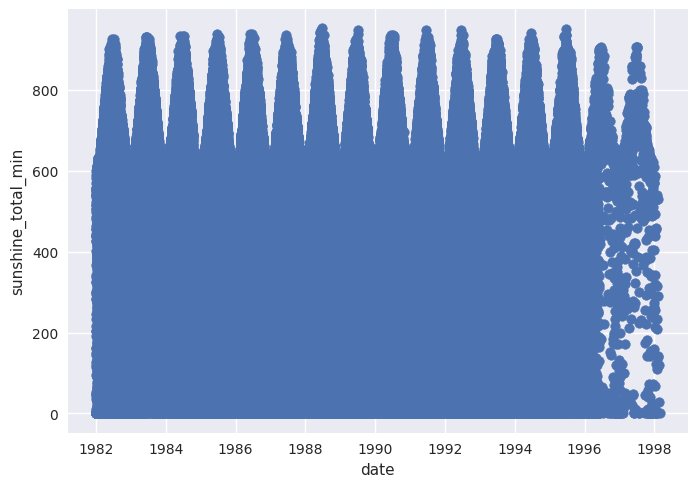

In [77]:
# subset country = United States for Global Weather data
plt.style.use('seaborn')
plt.figure(figsize=(7, 5))

wfeatures = ['avg_temp_c', 'min_temp_c',  'max_temp_c', 'precipitation_mm', 'snow_depth_mm', 'avg_wind_dir_deg', 'avg_wind_speed_kmh',
             'peak_wind_gust_kmh', 'avg_sea_level_pres_hpa', 'sunshine_total_min']

 # scatter plots
x = cities_weather_subset['date']

for col in wfeatures:
      y = cities_weather_subset[col]
      plt.scatter(x, y)
      plt.xlabel('date')
      plt.ylabel(col)
      plt.show()

# Visualize Time Series

source - https://www.kaggle.com/code/prashant111/complete-guide-on-time-series-analysis-in-python
<blockquote>
Copied the code for visualizing the time series.
For the visual timeseries analysis included US data subset for both max_temp_c and avg_temp_c and Global data for max_temp_c.
</blockquote>

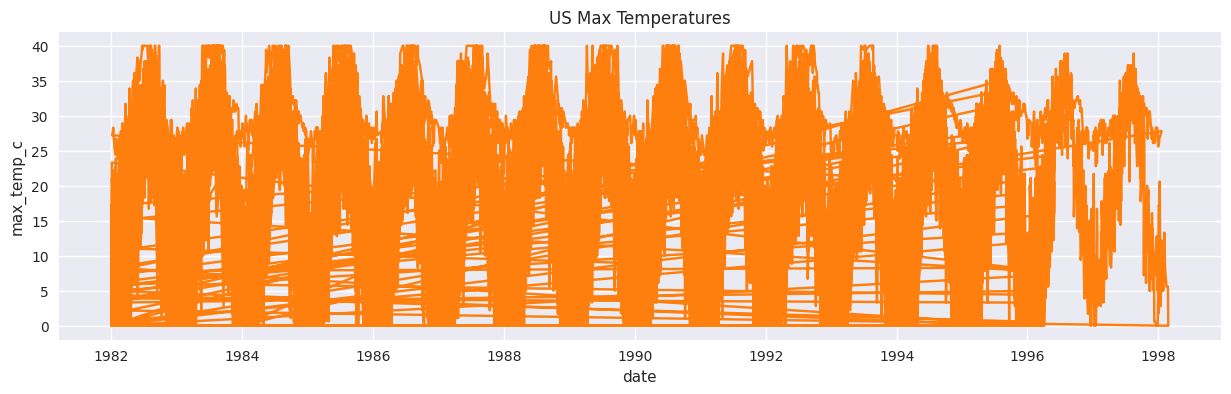

In [78]:
# US subset Max Temperature
def plot_df(df, x, y, title="US Weather data", xlabel='date', ylabel='max_temp_c', dpi=100):
    plt.figure(figsize=(15,4), dpi=dpi)
    plt.plot(x, y, color='tab:orange')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(cities_weather_subset, x=cities_weather_subset['date'], y=cities_weather_subset['max_temp_c'], title='US Max Temperatures')

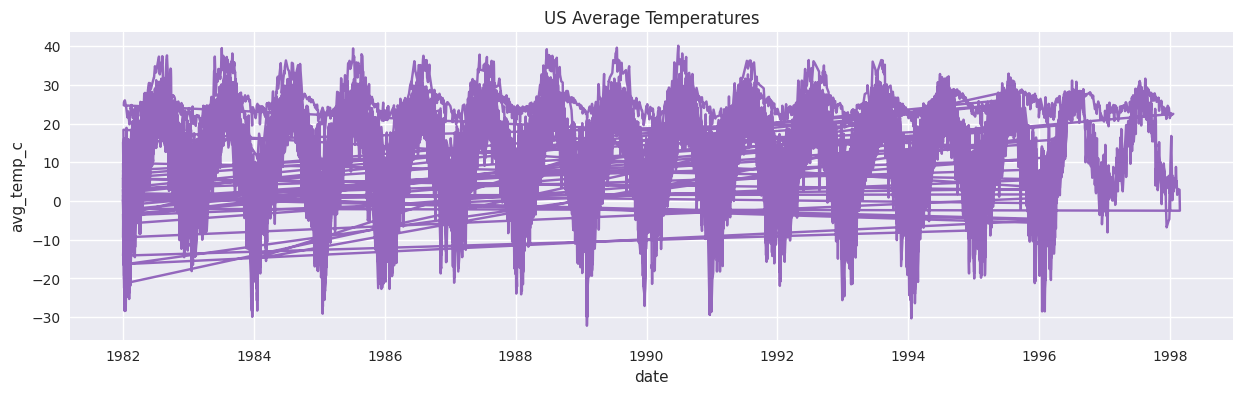

In [79]:
# US subset Min Temperature
def plot_df(df, x, y, title="US Weather data", xlabel='date', ylabel='avg_temp_c', dpi=100):
    plt.figure(figsize=(15,4), dpi=dpi)
    plt.plot(x, y, color='tab:purple')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(cities_weather_subset, x=cities_weather_subset['date'], y=cities_weather_subset['avg_temp_c'], title='US Average Temperatures')

<blockquote>Let's review global data to review the whole time range up to 2022, since the US subset only went up to 1998.</blockquote>

In [80]:
print(f"global weather shape: {cities_weather.shape}")
print(f"US subset shape: {cities_weather_subset.shape}")

global weather shape: (270987, 16)
US subset shape: (89480, 16)


<blockquote> For the visualization below I went back to the non country filtered dataframe.
Other options to possibly observe in addition to 'max_temp_c'
'avg_temp_c', 'min_temp_c', 'avg_sea_level_pres_hpa', 'sunshine_total_min'
</blockquote>    

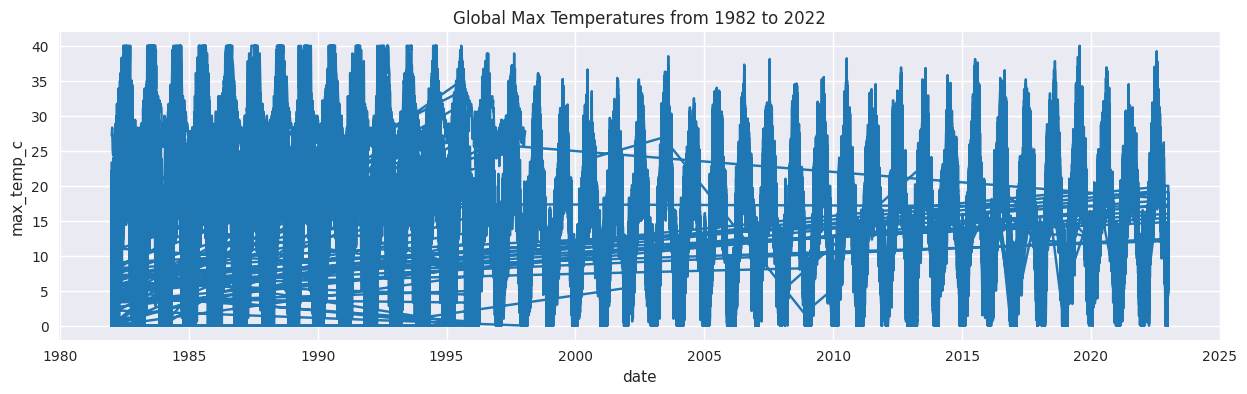

In [81]:
# cities_weather - all countries
def plot_df(df, x, y, title="", xlabel='date', ylabel='max_temp_c', dpi=100):
    plt.figure(figsize=(15,4), dpi=dpi)
    plt.plot(x, y, color='tab:blue')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(cities_weather, x=cities_weather['date'], y=cities_weather['max_temp_c'], title='Global Max Temperatures from 1982 to 2022')

source https://www.kaggle.com/code/prashant111/complete-guide-on-time-series-analysis-in-python
<blockquote>
Might remove this visual (below Two Sided View) since the notebook mentions 
'all the values are positive, we can show this on both sides of the Y axis to emphasize the growth.'
</blockquote>

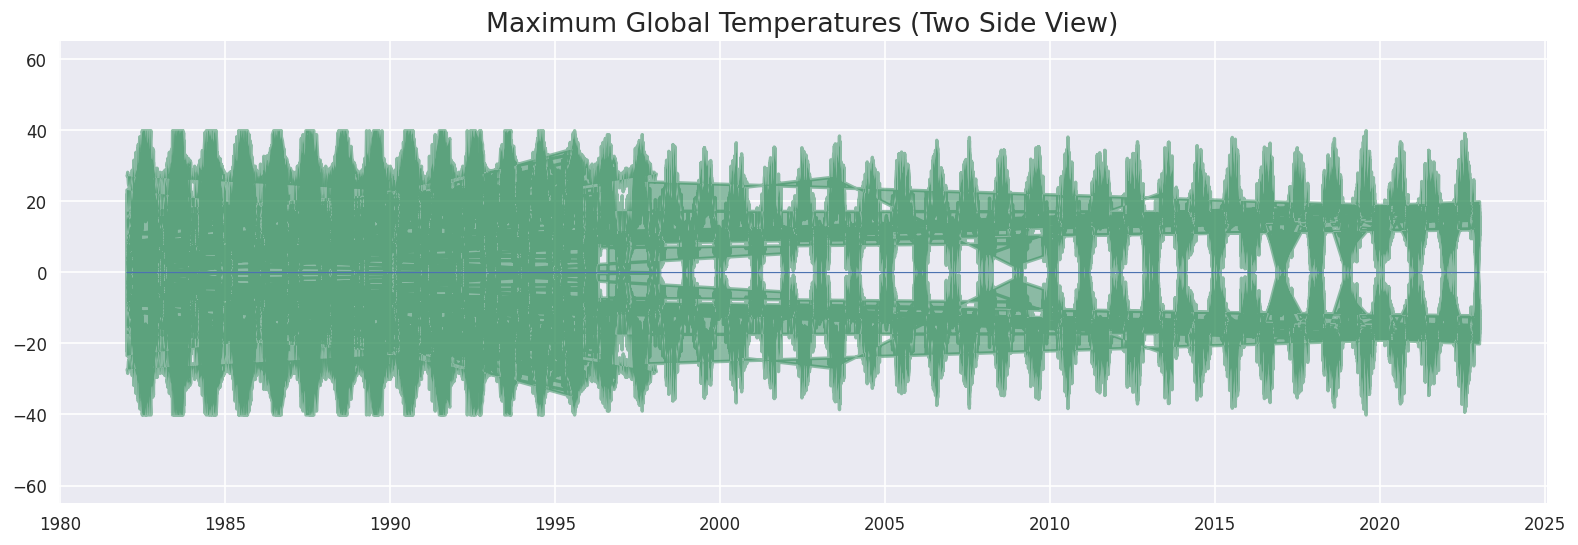

In [82]:
# Two Side View
x = cities_weather['date'].values
y1 = cities_weather['max_temp_c'].values

# Plot
fig, ax = plt.subplots(1, 1, figsize=(16,5), dpi= 120)
plt.fill_between(x, y1=y1, y2=-y1, alpha=0.5, linewidth=2, color='seagreen')
plt.ylim(-65, 65)
plt.title('Maximum Global Temperatures (Two Side View)', fontsize=16)
plt.hlines(y=0, xmin=np.min(cities_weather['date']), xmax=np.max(cities_weather['date']), linewidth=.75)
plt.show()


## Patterns in a Time Series

source https://www.kaggle.com/code/prashant111/complete-guide-on-time-series-analysis-in-python

Visualizations
- Decomposition of a Time Series
- Detrend a Time Series
- Autocorrelation and Partial Autocorrelation Functions
- Lag plots

Composition of Time Series
- trend
- seasonality
- cyclic (residuals)

##### Trend and Seasonality of a Timeseries

<blockquote>Visualize the Trend and Seasonality by plotting the date and max_temp_c columns</blockquote>

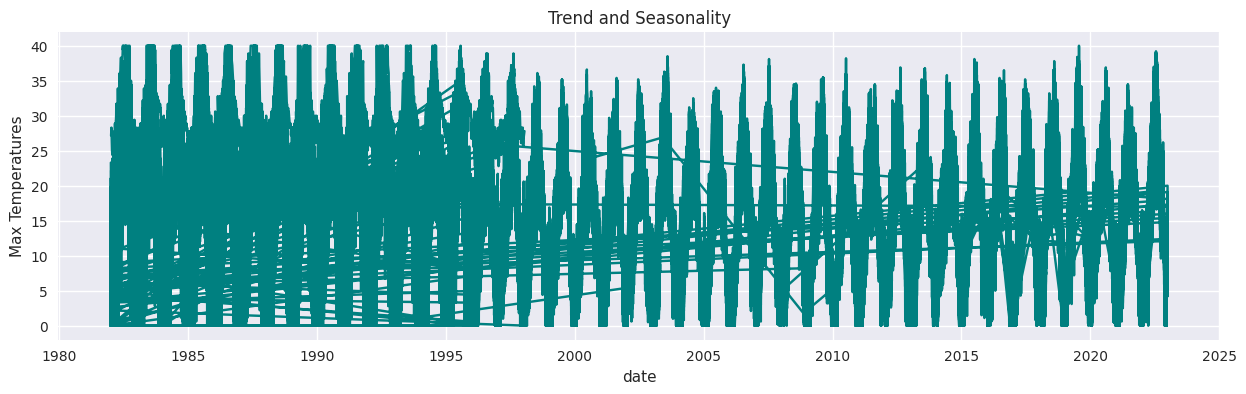

In [83]:
def plot_df(df, x, y, title="", xlabel='date', ylabel='Max Temperatures', dpi=100):
    plt.figure(figsize=(15,4), dpi=dpi)
    plt.plot(x, y, color='teal')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(cities_weather, x=cities_weather['date'], y=cities_weather['max_temp_c'], title='Trend and Seasonality')

##### Decomposition of a Time Series

<blockquote>Visualize the seasonal decompose function</blockquote>

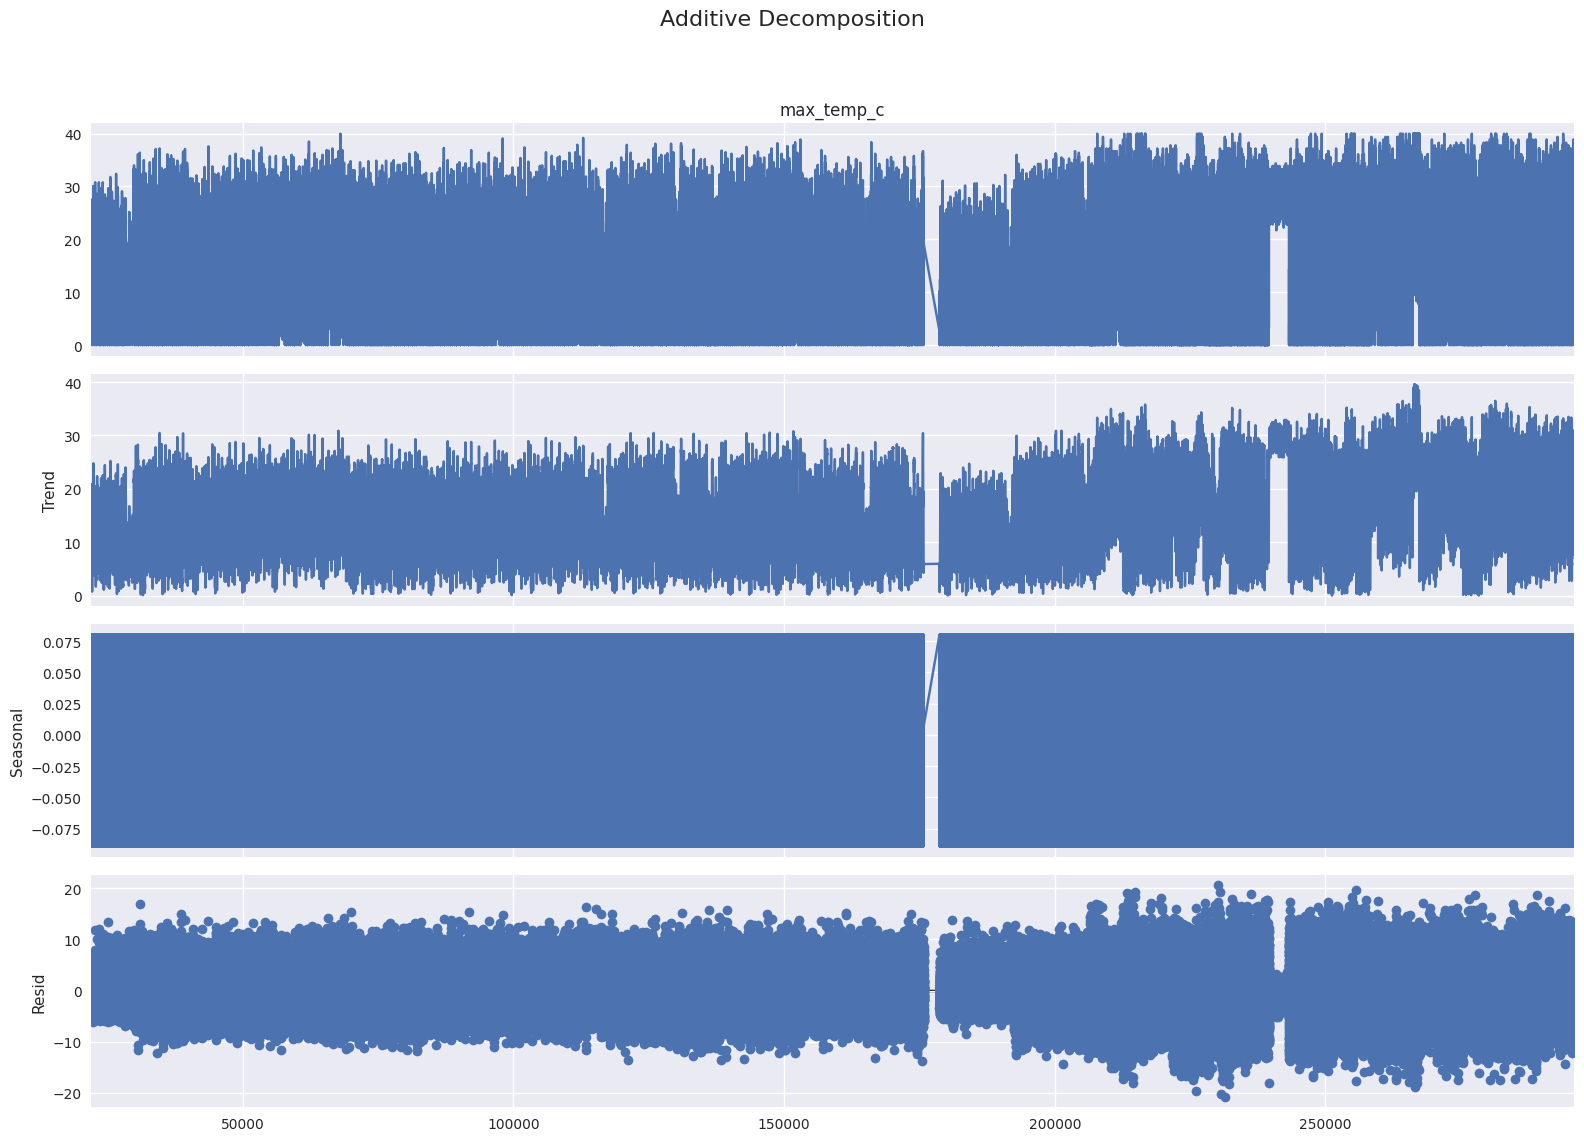

In [84]:
# Additive Decomposition
additive_decomposition = seasonal_decompose(cities_weather['max_temp_c'], model='additive', period=30)

# Plot
plt.rcParams.update({'figure.figsize': (16,12)})

additive_decomposition.plot().suptitle('Additive Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

 ##### Detrend a Time Series

<blockquote>Visualize the detrend function</blockquote>

Text(0.5, 1.0, 'Max Temp (C) detrended')

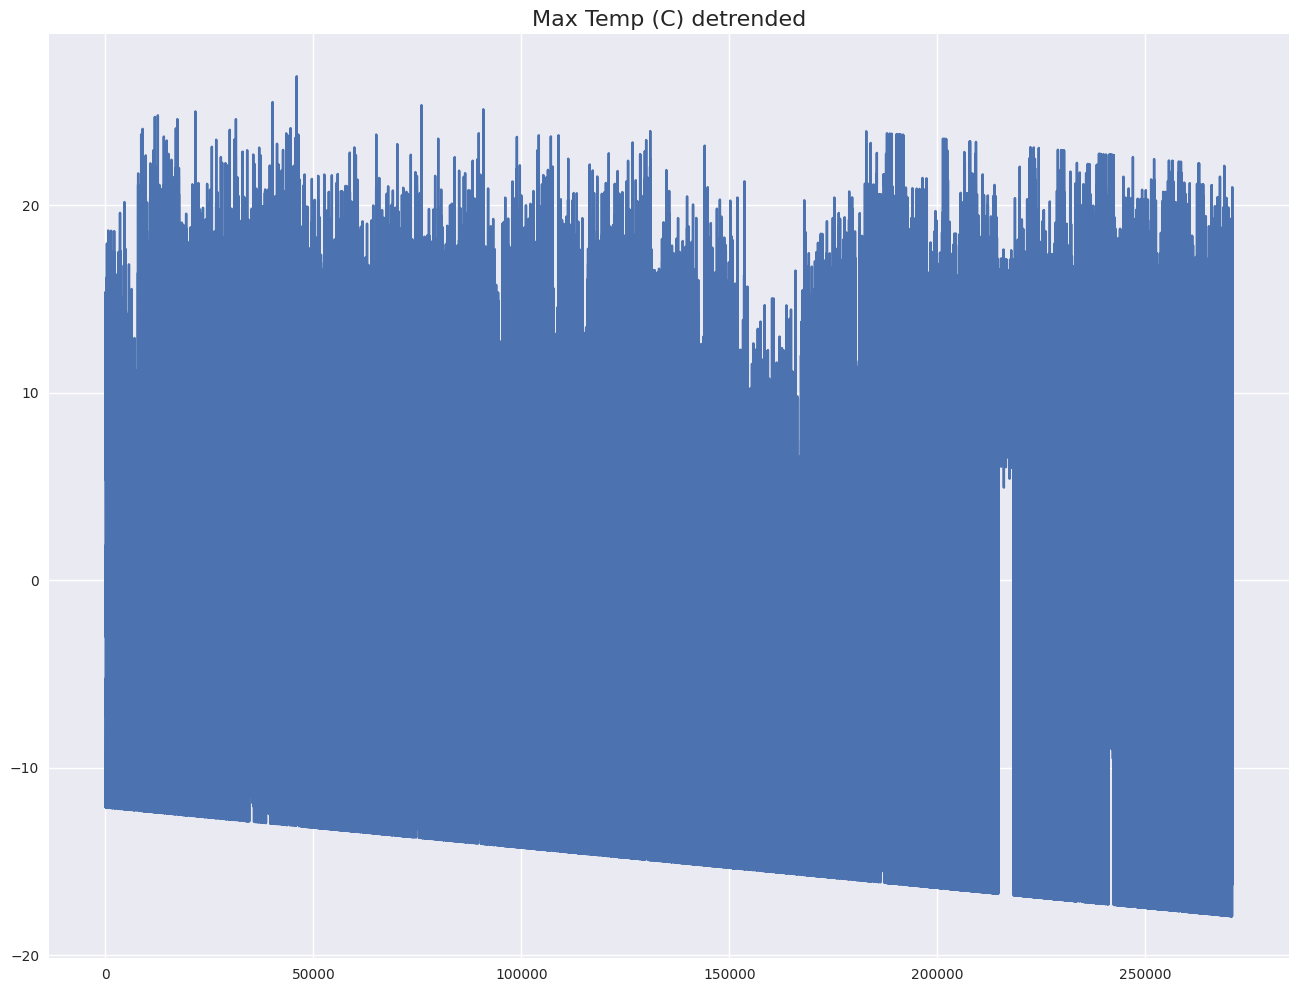

In [85]:
detrended = signal.detrend(cities_weather['max_temp_c'].values)
plt.plot(detrended)
plt.title('Max Temp (C) detrended', fontsize=16)

<blockquote>Visualize the seasonal decompose function</blockquote>

Text(0.5, 1.0, 'Max Temp (C) detrended')

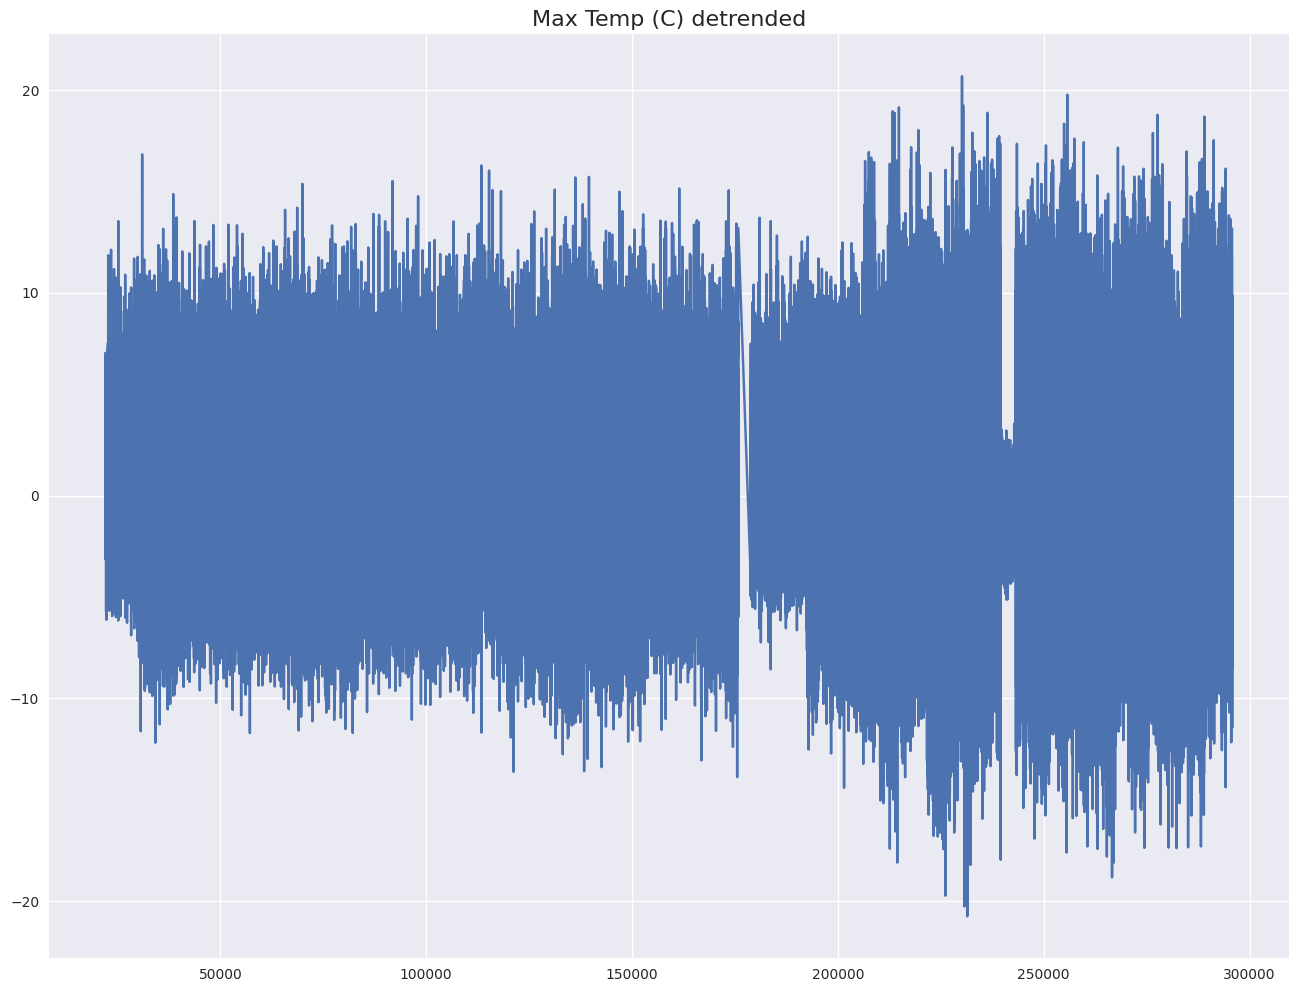

In [86]:
# Using statmodels: Subtracting the Trend Component
result_add = seasonal_decompose(cities_weather['max_temp_c'], model='additive', period=30)
detrended = cities_weather['max_temp_c'].values - result_add.trend
plt.plot(detrended)
plt.title('Max Temp (C) detrended', fontsize=16)

##### Autocorrelation and Partial Autocorrelation Functions

<blockquote>Visualize the autocorrelation and Partial Autocorrelation function</blockquote>

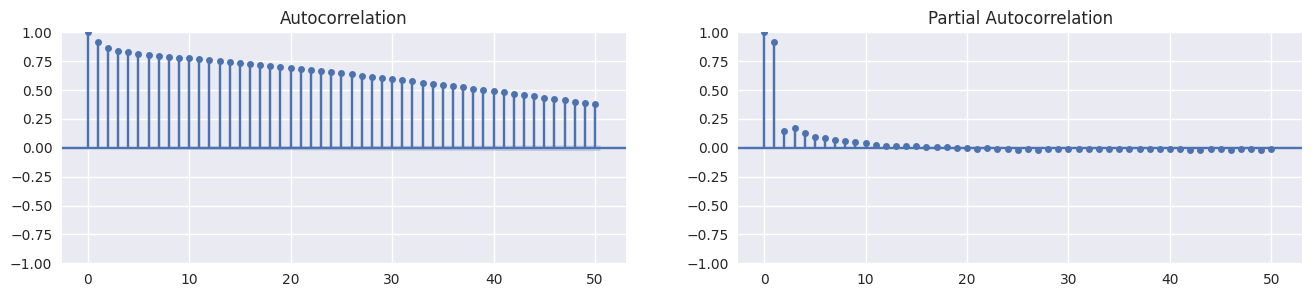

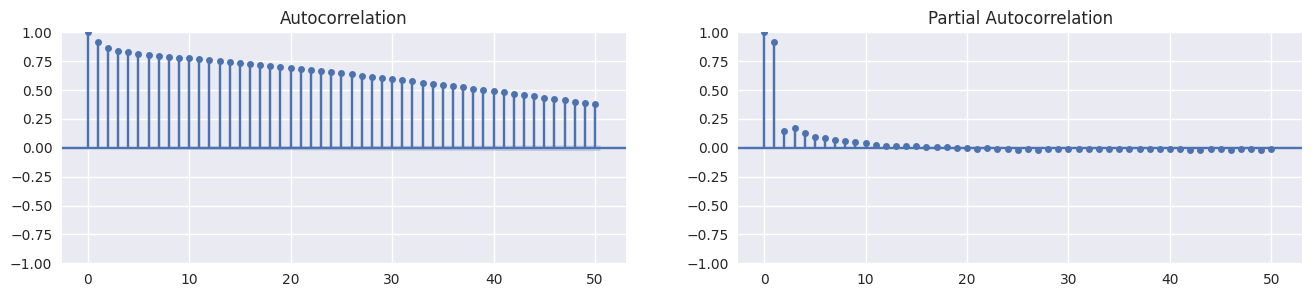

In [87]:
# Draw Plot
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(cities_weather['max_temp_c'].tolist(), lags=50, ax=axes[0])
plot_pacf(cities_weather['max_temp_c'].tolist(), lags=50, ax=axes[1])

##### Lag Plots

<blockquote>Visualize the Lag Plots</blockquote>

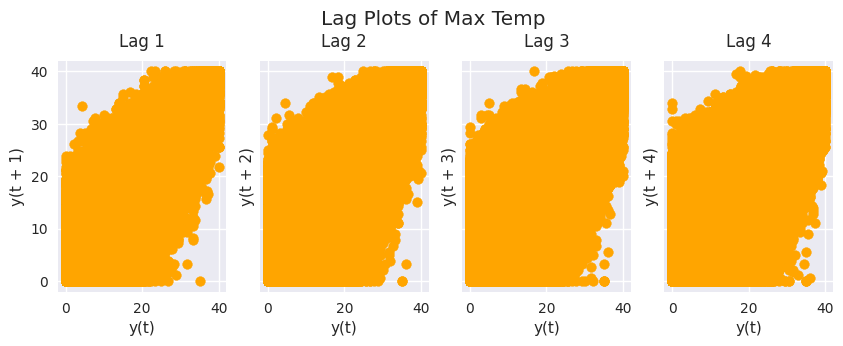

In [88]:
# Lag Plots
plt.rcParams.update({'ytick.left' : False, 'axes.titlepad':10})

# Plot
fig, axes = plt.subplots(1, 4, figsize=(10,3), sharex=True, sharey=True, dpi=100)
for i, ax in enumerate(axes.flatten()[:4]):
    lag_plot(cities_weather['max_temp_c'], lag=i+1, ax=ax, c='orange')
    ax.set_title('Lag ' + str(i+1))

fig.suptitle('Lag Plots of Max Temp', y=1.05)
plt.show()

# Model Time Series

### ADF Test

source - https://www.oreilly.com/library/view/time-series-forecasting/9781617299889/

<blockquote>ADF Test - review the staionarity of the data</blockquote>

In [89]:
ADF_result = adfuller(cities_weather['max_temp_c'])

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]:.3f}')

ADF Statistic: -52.92208172167799
p-value: 0.000


##### With a large negative ADF Statistic and a p-value much smaller than 0.05, the series is stationary.

<blockquote>
If the ADF statistic was not a large negative number and the p-value was not smaller than 0.05, the series would not be stationary. Being non-stationary would require applied transformations on the series. To stabilize the trend a x-order differencing can be applied (noted below).

<code>cities_weather_diff = np.diff(cities_weather['max_temp_c'], n=x)</code> 

To verify re-check test for stationarity using the ADF test
    
<code> ADF_result = adfuller(cities_weather_diff)</code>   
 
<code> print(f'ADF Statistic: {ADF_result[0]}')</code>
<code> print(f'p-value: {ADF_result[1]}')</code>

Once the order of the moving average is identified the process can be moved to fit the model to the training/test data and start forecasting.
</blockquote>

### Encode data for modeling

source : https://www.kaggle.com/code/discdiver/category-encoders-examples/notebook

Classic Encoder - sklearn.preprocessing.LabelEncoder() code

<blockquote>Encode data for modeling the time series analysis</blockquote>

<blockquote>Making two copies of the encoded dataframe to apply different percentage splits.</blockquote>

In [91]:
# Make a copy of the dataframe to encode categorical data
cities_weather_enc = cities_weather.copy()
cities_weather_enc2 = cities_weather_enc.copy()  # copy of dataframe with different percentage split

<blockquote> Encode categorical variables for modeling</blockquote>

In [92]:
# Label_encoder object
label_encoder = LabelEncoder()

# Encode label in column. 
cities_weather_enc['city_name']= label_encoder.fit_transform(cities_weather_enc['city_name'])
# Encode label in column. 
cities_weather_enc['country']= label_encoder.fit_transform(cities_weather_enc['country'])
# Encode label in column. 
cities_weather_enc['season']= label_encoder.fit_transform(cities_weather_enc['season'])

# display updated encoded dataframe - seasons, countries, cities
cities_weather_enc.head(3)

date  season  avg_temp_c  min_temp_c  max_temp_c  \
22024 1996-08-01       2        18.6        15.6        23.0   
22025 1996-08-02       2        17.2        14.9        19.3   
22026 1996-08-03       2        16.6        14.7        18.6   

       precipitation_mm  snow_depth_mm  avg_wind_dir_deg  avg_wind_speed_kmh  \
22024               0.0            0.0             219.0                15.1   
22025               0.0            0.0             263.0                24.5   
22026               0.0            0.0             291.0                25.2   

       peak_wind_gust_kmh  avg_sea_level_pres_hpa  sunshine_total_min  \
22024                36.0                  1013.7               270.0   
22025                45.7                  1018.7               588.0   
22026                39.2                  1024.7               618.0   

       city_name  country   latitude  longitude  
22024         45        0  55.432998  11.566702  
22025         45        0  55.432998  11.566702  
22026         45        0  55.432998  11.566702

#### Train - Test

source - can't seem to find the source for the code snippet below

<blockquote>

The code had a 0.9 as the split percentage can try .80 for other models since making another copy
    
I tried splitting the data with sklearn train-test function - but it didn't seem to work. 

I also had another bug in the code so that might have also been contributing to the issue.
</blockquote>    

In [93]:
#Test - Train split for Simple Moving Average Model
split = int(0.9*len(cities_weather_enc))                       

# select the rows to use for training the forecasting model.
train = cities_weather_enc[0:split]                                

# assign the remaining rows to evaluate forecasting model performance           
test = cities_weather_enc[split:] 

#Test - Train split for MA, AR, ARMA, ARIMA, SARIMA
split_indx = int(0.8*len(cities_weather_enc2))   # split into train and test

train_data = cities_weather_enc2[0:split_indx]    # select the rows for training model.                            
test_data = cities_weather_enc2[split_indx:]      # rows to evaluate forecasting model performance  

### Simple Moving Average

source - https://www.kaggle.com/code/gauravduttakiit/timeseries-forecasting-with-simple-moving-average
<blockquote>
The code included a window of 2 - but changed to 3 while talking to Shilpa she mentioned it seemed too low. 
Having such a small window will include lots of noise.
Realized with reviewing annual data the window is too small - try 7, 12, 30, 52?

<b>After reviewing the code again it actually has 12 not 2 will try with 12 to see if it minimizes some of the noise</b>
<blockquote>    

##### Model SMA

In [98]:
# WINDOW SIZE - the current data point and the previous data points in each calculation.
MA_WINDOW = 52 #30 #12 

# MODEL - Calculate the rolling mean (moving average) of max temperature for the entire dataset
# add new rolling mean to new sma_forecast column 
cities_weather_enc['sma_forecast'] = cities_weather_enc['max_temp_c'].rolling(MA_WINDOW).mean()

# PREDICT - Extend the rolling mean forecast to the test dataset
cities_weather_enc['sma_forecast'][split:] = cities_weather_enc['sma_forecast'].iloc[split-1]

##### Visualize SMA

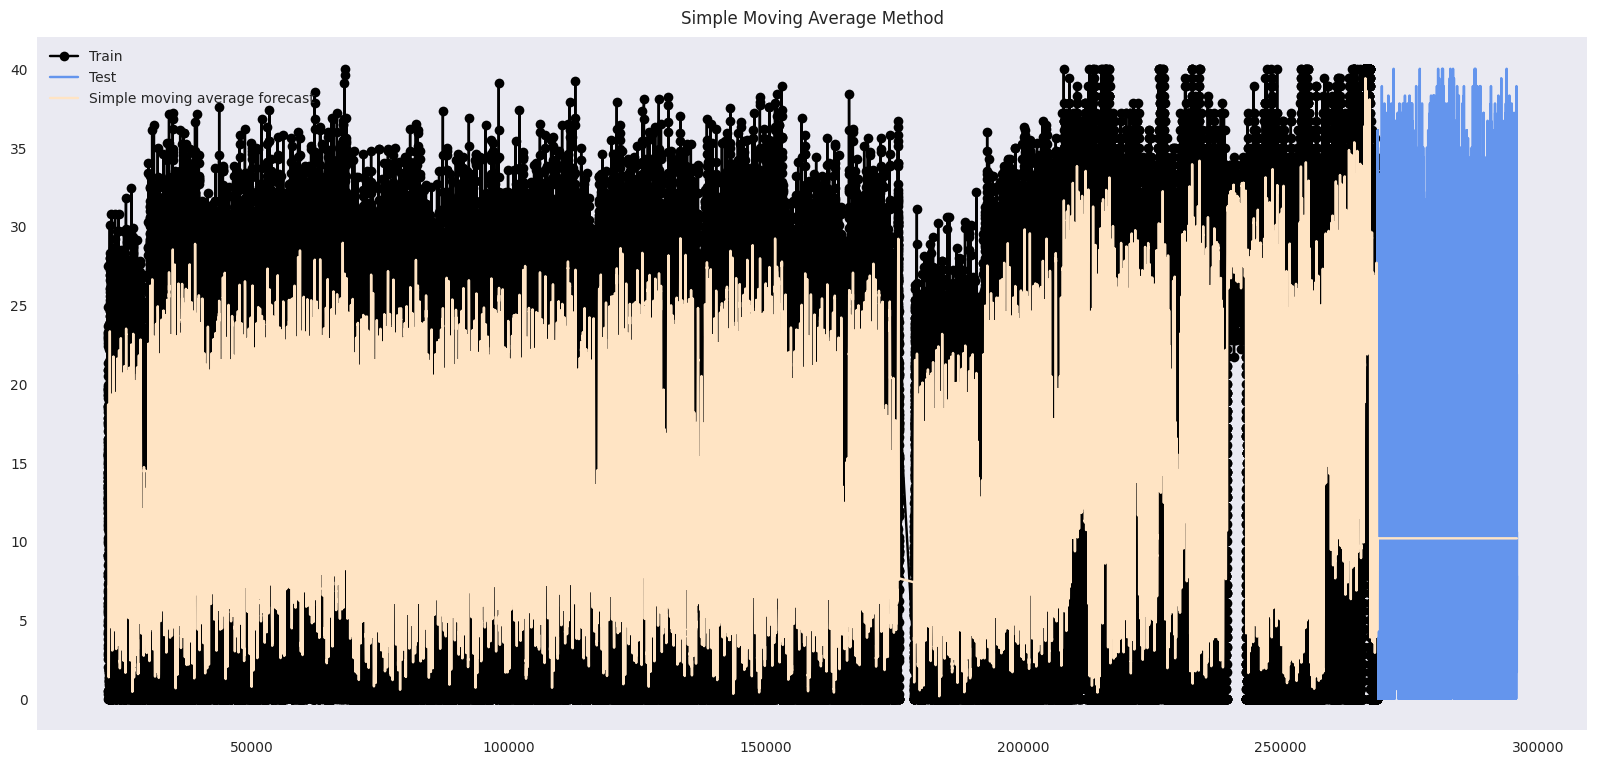

In [99]:
# Visualize Simple Moving Average
plt.figure(figsize=(20,9))
plt.grid()
plt.plot(train['max_temp_c'], label='Train', color='black', marker='o')
plt.plot(test['max_temp_c'], label='Test', color='cornflowerblue')
plt.plot(cities_weather_enc['sma_forecast'], label='Simple moving average forecast', color='bisque')
plt.legend(loc='best')
plt.title('Simple Moving Average Method')
plt.show()

##### Forecast Error SMA

In [100]:
# Forecasting error for the Simple Moving Average
# Calculate and round the Root Mean Squared Error (RMSE) for the forecast
test_actual_values = test['max_temp_c']                        # Actual (expected) temperature - target
forecasted_values = cities_weather_enc['sma_forecast'][split:] # Forecasted temperature values
forecasted_values

268813    10.186538
268814    10.186538
268815    10.186538
268816    10.186538
268817    10.186538
            ...    
295907    10.186538
295908    10.186538
295909    10.186538
295910    10.186538
295911    10.186538
Name: sma_forecast, Length: 27099, dtype: float64

In [101]:
# Calculate Mean Absolute Error (MAE) and then take the square root to get RMSE
mae = mean_absolute_error(test_actual_values, forecasted_values)
mse = mean_squared_error(test_actual_values, forecasted_values)
rmse = np.sqrt(mse).round(2)

print(f'\n MAE: {mae}\n RMSE: {rmse}\n')


 MAE: 11.39897335127325
 RMSE: 13.55



####  Non-machine learning baseline

<blockquote>Just added the mean of the data in the mix as a reference</blockquote>

In [102]:
mean_value = cities_weather_enc['max_temp_c'].mean()
print(f'\n Mean: {mean_value}')


 Mean: 15.028705067032735


<blockquote>
source https://machinelearningmastery.com/time-series-forecasting-methods-in-python-cheat-sheet/
For the MA, ARMA, ARIMA, and SARIMA models    

The code didn't seem to work exactly as-is for the datasets I am using - initially throught the error was in the forecasting error code. After reviewing the other articles noticed what was missing
model_fit.predict(len(data), len(data))
by adding -1 to the second parameter seemed to help and also added typ="levels" to the MA and ARMA models.
Also removed from the ARIMA and SARMIMA model the + n_forecast that I found in another blog.
</blockquote>    

### Moving Average Method using ARIMA (MA)

<blockquote> For the MA code I keep the same order (0,0,1)</blockquote>

In [108]:
# fit model for MA
ma_model = ARIMA(train_data['max_temp_c'], order=(0, 0, 1))
ma_model_fit = ma_model.fit()

# make prediction                                      
pred_ma = ma_model_fit.predict(start=len(train_data), end=len(cities_weather_enc2)-1, typ="levels") 
print(pred_ma)

216789    21.379558
216790    14.174852
216791    14.174852
216792    14.174852
216793    14.174852
            ...    
270982    14.174852
270983    14.174852
270984    14.174852
270985    14.174852
270986    14.174852
Name: predicted_mean, Length: 54198, dtype: float64


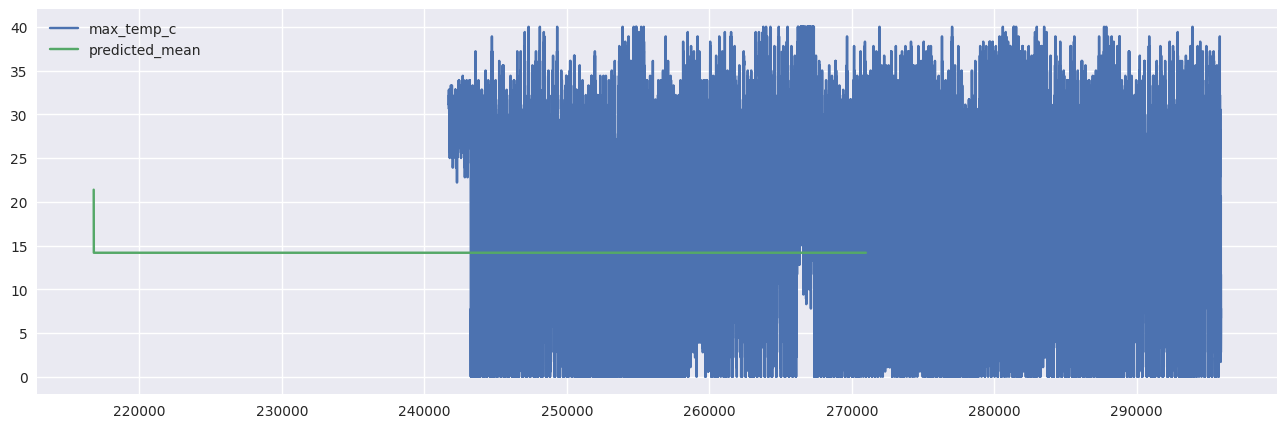

In [109]:
test_data['max_temp_c'].plot(figsize = (16,5), legend=True)
pred_ma.plot(legend = True);

In [111]:
ma_mae = mean_absolute_error(test_data['max_temp_c'], pred_ma)
ma_mse = mean_squared_error(test_data['max_temp_c'], pred_ma) 
ma_rmse = np.sqrt(ma_mse)
print(f'\n MAE: {ma_mae}\n RMSE: {ma_rmse}')


 MAE: 10.212669282498519
 RMSE: 11.828096103476897


### Autoregressive Method using AutoReg (AR)

<blockquote>For the AR code I keep the same lags 4</blockquote>

In [113]:
# fit model for MA
ar_model = AutoReg(train_data['max_temp_c'], lags=4)
ar_model_fit = ar_model.fit()

# make prediction                                      
pred_ar = ar_model_fit.predict(start=len(train_data), end=len(cities_weather_enc2)-1) 
print(pred_ar)

216789    30.831767
216790    30.198426
216791    29.739208
216792    29.271231
216793    28.768327
            ...    
270982    14.176422
270983    14.176422
270984    14.176422
270985    14.176422
270986    14.176422
Length: 54198, dtype: float64


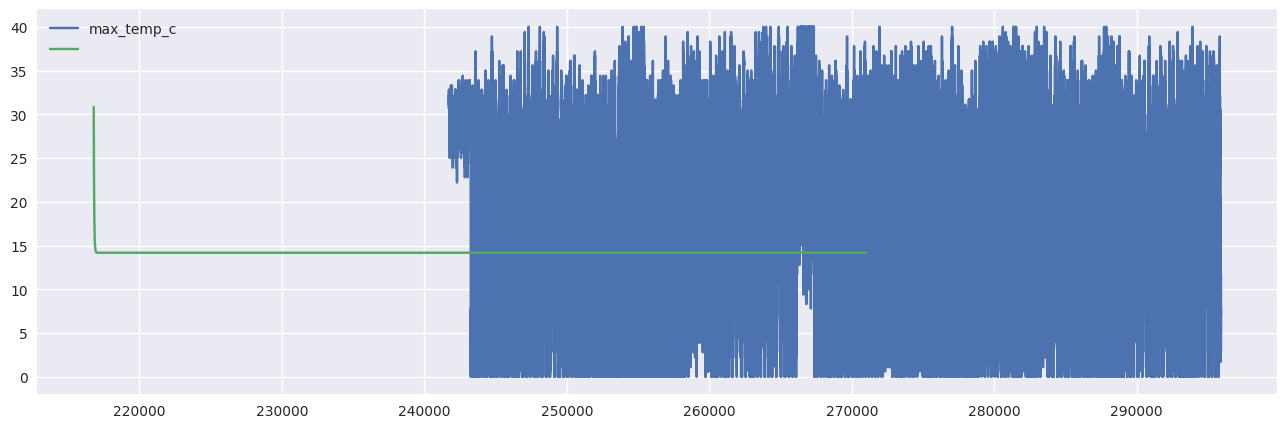

In [114]:
test_data['max_temp_c'].plot(figsize = (16,5), legend=True)
pred_ar.plot(legend = True);

In [70]:
ar_mae = mean_absolute_error(test_data['max_temp_c'], pred_ar)
ar_mse_error = mean_squared_error(test_data['max_temp_c'], pred_ar) 
ar_rmse_error = np.sqrt(ar_mse_error)

print(f'\n MAE: {ar_mae}\n RMSE: {ar_rmse_error}')


 MAE: 10.603189252963116
 RMSE: 12.432798907511053


### Autoregressive Moving Average (ARMA)

<blockquote>For the ARMA code I keep the same order (2,0,1)</blockquote>

In [117]:
# fit model for ARMA
arma_model = ARIMA(train['max_temp_c'], order=(2, 0, 1))
arma_model_fit = arma_model.fit()

# make prediction                                                 
pred_arma = arma_model_fit.predict(start=len(train_data), end=len(cities_weather_enc2)-1) 
print(pred_arma)

216789    31.255200
216790    30.833482
216791    30.801595
216792    31.190179
216793    31.540365
            ...    
270982    14.660911
270983    14.660911
270984    14.660911
270985    14.660911
270986    14.660911
Name: predicted_mean, Length: 54198, dtype: float64


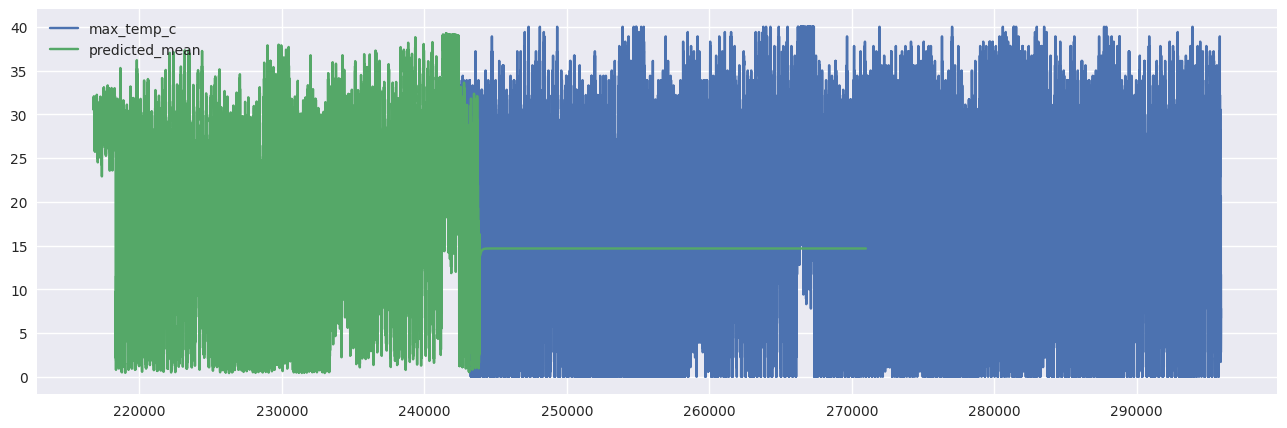

In [118]:
test_data['max_temp_c'].plot(figsize = (16,5), legend=True)
pred_arma.plot(legend = True);

In [73]:
arma_mae = mean_absolute_error(test_data['max_temp_c'], pred_arma)
arma_mse_error = mean_squared_error(test_data['max_temp_c'], pred_arma) 
arma_rmse_error = np.sqrt(arma_mse_error)

print(f'\n MAE: {arma_mae}\n RMSE: {arma_rmse_error}\n')


 MAE: 6.981459287112043
 RMSE: 9.194076918777288



### Autoregressive Integrated Moving Average (ARIMA)

<blockquote> For the ARIMA code I keep the same order (1,1,1)</blockquote>

In [119]:
# fit model for ARIMA
arima_model = ARIMA(train['max_temp_c'], order=(1, 1, 1))
arima_model_fit = arima_model.fit()

# make prediction                                                     
pred_arima = arima_model_fit.predict(start=len(train_data), end=len(cities_weather_enc2)-1, typ='levels') 
print(pred_arima)

216789    31.740925
216790    31.316098
216791    31.284484
216792    31.676334
216793    32.028829
            ...    
270982    13.535673
270983    13.535673
270984    13.535673
270985    13.535673
270986    13.535673
Name: predicted_mean, Length: 54198, dtype: float64


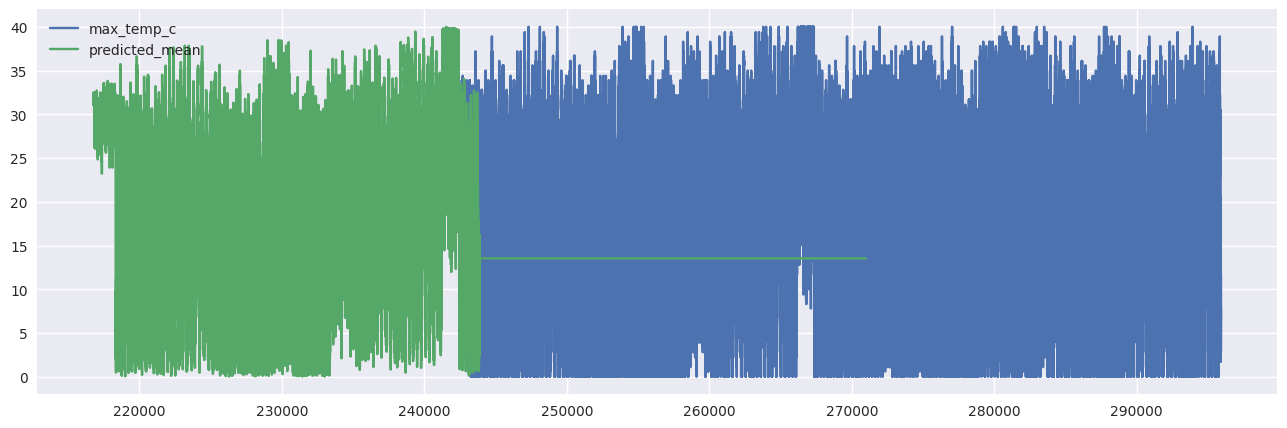

In [120]:
test_data['max_temp_c'].plot(figsize = (16,5), legend=True)
pred_arima.plot(legend = True);

In [75]:
arima_mae = mean_absolute_error(test_data['max_temp_c'], pred_arima)
arima_mse_error = mean_squared_error(test_data['max_temp_c'], pred_arima) 
arima_rmse_error = np.sqrt(arima_mse_error)

print("ARIMA Model Evaluation:")
print(f'\n MAE: {arima_mae}\n RMSE: {arima_rmse_error}\n')

ARIMA Model Evaluation:

 MAE: 7.096905183648478
 RMSE: 9.40089844314359



### Seasonal Autoregressive Integrated Moving-Average (SARIMA)

<blockquote> For the SARIMA I changed the order from (0,0,0,0) since it didn't include seasonality to randomly adding order 1,1,1,4 after reading the sklearn SARIMA model documentation</blockquote>

In [121]:
# fit model for SARIMA                                              
#sarima_model = SARIMAX(train['max_temp_c'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 4)) #works 
sarima_model = SARIMAX(train['max_temp_c'], order=(2, 0, 2), seasonal_order=(1, 1, 2, 4)) # switch up
sarima_model_fit = sarima_model.fit(disp=False)

# make prediction                                                    
pred_sarima = sarima_model_fit.predict(start=len(train_data), end=len(cities_weather_enc2)-1, typ='levels') 
print(pred_sarima)  

216789    31.223359
216790    30.800328
216791    30.788944
216792    31.187986
216793    31.533884
            ...    
270982    15.240904
270983    15.238190
270984    15.250756
270985    15.249460
270986    15.240904
Name: predicted_mean, Length: 54198, dtype: float64


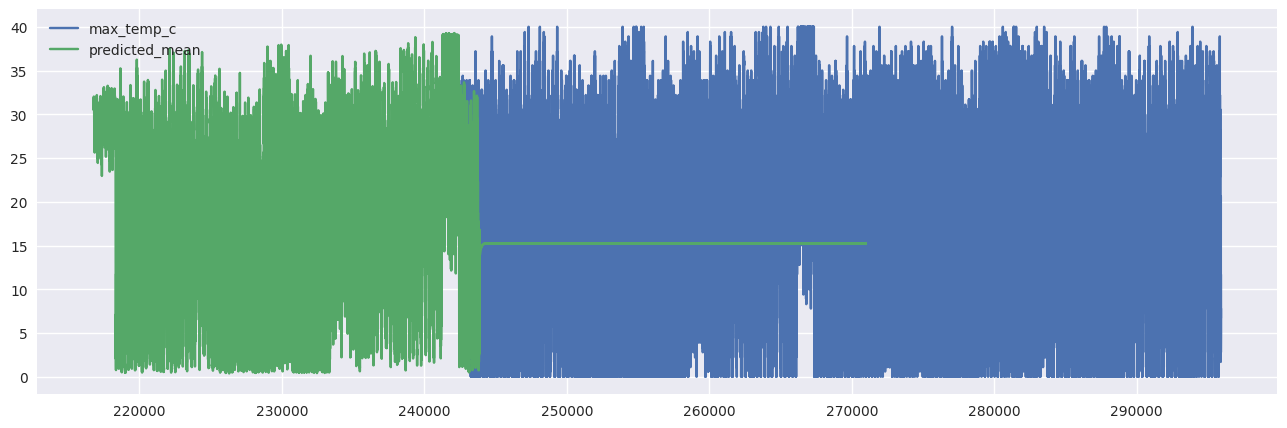

In [123]:
test_data['max_temp_c'].plot(figsize = (16,5), legend=True)
pred_sarima.plot(legend = True);

In [124]:
sarima_mae = mean_absolute_error(test_data['max_temp_c'], pred_sarima)
sarima_mse_error = mean_squared_error(test_data['max_temp_c'], pred_sarima)
sarima_rmse_error = np.sqrt(sarima_mse_error)

print("SARIMA Model Evaluation:")
print(f'\n MAE: {sarima_mae}\n RMSE: {sarima_rmse_error}\n')

SARIMA Model Evaluation:

 MAE: 6.587400432828214
 RMSE: 8.59727721316918



🔷🔷🔷PENDING🔷🔷🔷
<blockquote>
    
  
    
- Possibly work on dashboard - Dash or app   
    
- Try refactoring to write functions to modularize and minimize the code    
</blockquote>

### LSTM Forecast

source:  https://github.com/marcopeix/TimeSeriesForecastingInPython/blob/master/CH18/CH18_modeling.ipynb

<blockquote>just copied the code still need to modify variable names
Ran the code as-is and an error is generated on date column - not expecting datetime datatype need to create another copy and try changing the date to the index.
</blockquote>

In [58]:
cities_weather_lstm = cities_weather_enc.copy()

cities_weather_lstm = cities_weather_lstm.set_index("date")

In [71]:
cities_weather_lstm.head(3)

season  avg_temp_c  min_temp_c  max_temp_c  precipitation_mm  \
date                                                                       
1996-08-01       2        18.6        15.6        23.0               0.0   
1996-08-02       2        17.2        14.9        19.3               0.0   
1996-08-03       2        16.6        14.7        18.6               0.0   

            snow_depth_mm  avg_wind_dir_deg  avg_wind_speed_kmh  \
date                                                              
1996-08-01            0.0             219.0                15.1   
1996-08-02            0.0             263.0                24.5   
1996-08-03            0.0             291.0                25.2   

            peak_wind_gust_kmh  avg_sea_level_pres_hpa  sunshine_total_min  \
date                                                                         
1996-08-01                36.0                  1013.7               270.0   
1996-08-02                45.7                  1018.7               588.0   
1996-08-03                39.2                  1024.7               618.0   

            city_name  country   latitude  longitude  
date                                                  
1996-08-01         45        0  55.432998  11.566702  
1996-08-02         45        0  55.432998  11.566702  
1996-08-03         45        0  55.432998  11.566702

source:

In [75]:
column_indices = {name: i for i, name in enumerate(cities_weather_lstm.columns)}

n = len(cities_weather_lstm)
train_lstm = cities_weather_lstm[0:int(n*0.7)]
val_lstm = cities_weather_lstm[int(n*0.7):int(n*0.9)]
test_lstm = cities_weather_lstm[int(n*0.9):]

num_features = cities_weather_lstm.shape[1]

In [76]:
# DataWindow class

class DataWindow():
    def __init__(self, input_width, label_width, shift, 
                 train_df=train_lstm, val_df=val_lstm, test_df=test_lstm, 
                 label_columns=None):
        
        self.train_df = train_lstm
        self.val_df = val_lstm
        self.test_df = test_lstm
        
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_lstm.columns)}
        
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels
    
    def plot(self, model=None, plot_col='max_temp_c', max_subplots=3):
        inputs, labels = self.sample_batch
        
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index

            if label_col_index is None:
              continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64)
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='orange', s=64)

            if n == 0:
              plt.legend()

        plt.xlabel('Time (h)')
        
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )
        
        ds = ds.map(self.split_to_inputs_labels)
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

def compile_and_fit(model, window, patience=3, max_epochs=50):
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=patience,
                                   mode='min')
    
    model.compile(loss=MeanSquaredError(),
                  optimizer=Adam(),
                  metrics=[MeanAbsoluteError()])
    
    history = model.fit(window.train,
                       epochs=max_epochs,
                       validation_data=window.val,
                       callbacks=[early_stopping])
    
    return history

In [77]:
def compile_and_fit(model, window, patience=3, max_epochs=50):
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=patience,
                                   mode='min')
    
    model.compile(loss=MeanSquaredError(),
                  optimizer=Adam(),
                  metrics=[MeanAbsoluteError()])
    
    history = model.fit(window.train,
                       epochs=max_epochs,
                       validation_data=window.val,
                       callbacks=[early_stopping])
    
    return history

In [78]:
column_indices = {name: i for i, name in enumerate(train_lstm.columns)}

In [94]:
column_indices

{'season': 0,
 'avg_temp_c': 1,
 'min_temp_c': 2,
 'max_temp_c': 3,
 'precipitation_mm': 4,
 'snow_depth_mm': 5,
 'avg_wind_dir_deg': 6,
 'avg_wind_speed_kmh': 7,
 'peak_wind_gust_kmh': 8,
 'avg_sea_level_pres_hpa': 9,
 'sunshine_total_min': 10,
 'city_name': 11,
 'country': 12,
 'latitude': 13,
 'longitude': 14}

In [80]:
# Baseline models
multi_window = DataWindow(input_width=24, label_width=24, shift=24, label_columns=['max_temp_c'])

In [81]:
# Repeat last value
class MultiStepLastBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        if self.label_index is None:
            return tf.tile(inputs[:, -1:, :], [1, 24, 1])
        return tf.tile(inputs[:, -1:, self.label_index:], [1, 24, 1])

In [83]:
baseline_last = MultiStepLastBaseline(label_index=column_indices['max_temp_c'])

baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

val_performance = {}
performance = {}

val_performance['Baseline - Last'] = baseline_last.evaluate(multi_window.val)
performance['Baseline - Last'] = baseline_last.evaluate(multi_window.test, verbose=0)

1693/1693 [==============================] - 5s 3ms/step - loss: 107715.5234 - mean_absolute_error: 152.2111


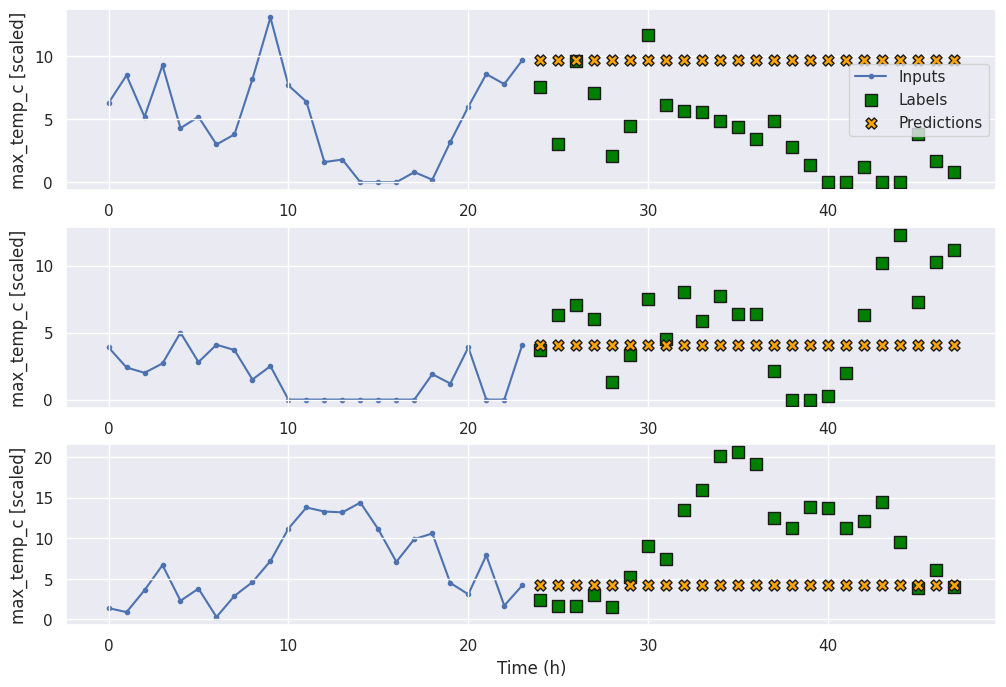

In [84]:
multi_window.plot(baseline_last)

In [91]:
# Dense model

dense = Sequential([
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(dense, multi_window)

val_performance['Dense'] = dense.evaluate(multi_window.val)
performance['Dense'] = dense.evaluate(multi_window.test, verbose=0)

Epoch 1/50
5927/5927 [==============================] - 28s 5ms/step - loss: 33.3063 - mean_absolute_error: 4.5560 - val_loss: 75.1935 - val_mean_absolute_error: 7.2357
Epoch 2/50
5927/5927 [==============================] - 27s 4ms/step - loss: 29.1844 - mean_absolute_error: 4.2504 - val_loss: 72.2740 - val_mean_absolute_error: 7.0975
Epoch 3/50
5927/5927 [==============================] - 27s 5ms/step - loss: 24.1777 - mean_absolute_error: 3.9054 - val_loss: 62.0419 - val_mean_absolute_error: 6.5298
Epoch 4/50
5927/5927 [==============================] - 27s 5ms/step - loss: 23.4324 - mean_absolute_error: 3.8495 - val_loss: 59.7913 - val_mean_absolute_error: 6.2918
Epoch 5/50
5927/5927 [==============================] - 29s 5ms/step - loss: 23.0823 - mean_absolute_error: 3.8202 - val_loss: 58.5568 - val_mean_absolute_error: 6.1757
Epoch 6/50
5927/5927 [==============================] - 28s 5ms/step - loss: 22.8682 - mean_absolute_error: 3.8029 - val_loss: 63.2175 - val_mean_absolute_

In [92]:
lstm_model = Sequential([
    LSTM(32, return_sequences=True),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(lstm_model, multi_window)

val_performance['LSTM'] = lstm_model.evaluate(multi_window.val)
performance['LSTM'] = lstm_model.evaluate(multi_window.test, verbose=0)

Epoch 1/50
5927/5927 [==============================] - 91s 15ms/step - loss: 53.3292 - mean_absolute_error: 5.6679 - val_loss: 80.3615 - val_mean_absolute_error: 7.5988
Epoch 2/50
5927/5927 [==============================] - 88s 15ms/step - loss: 28.1711 - mean_absolute_error: 4.1887 - val_loss: 74.8725 - val_mean_absolute_error: 7.2515
Epoch 3/50
5927/5927 [==============================] - 88s 15ms/step - loss: 26.7769 - mean_absolute_error: 4.0837 - val_loss: 70.3388 - val_mean_absolute_error: 7.0147
Epoch 4/50
5927/5927 [==============================] - 85s 14ms/step - loss: 25.7432 - mean_absolute_error: 4.0101 - val_loss: 70.1399 - val_mean_absolute_error: 7.0036
Epoch 5/50
5927/5927 [==============================] - 85s 14ms/step - loss: 24.5141 - mean_absolute_error: 3.9213 - val_loss: 68.6356 - val_mean_absolute_error: 6.9351
Epoch 6/50
5927/5927 [==============================] - 84s 14ms/step - loss: 24.0827 - mean_absolute_error: 3.8898 - val_loss: 67.9089 - val_mean_abs

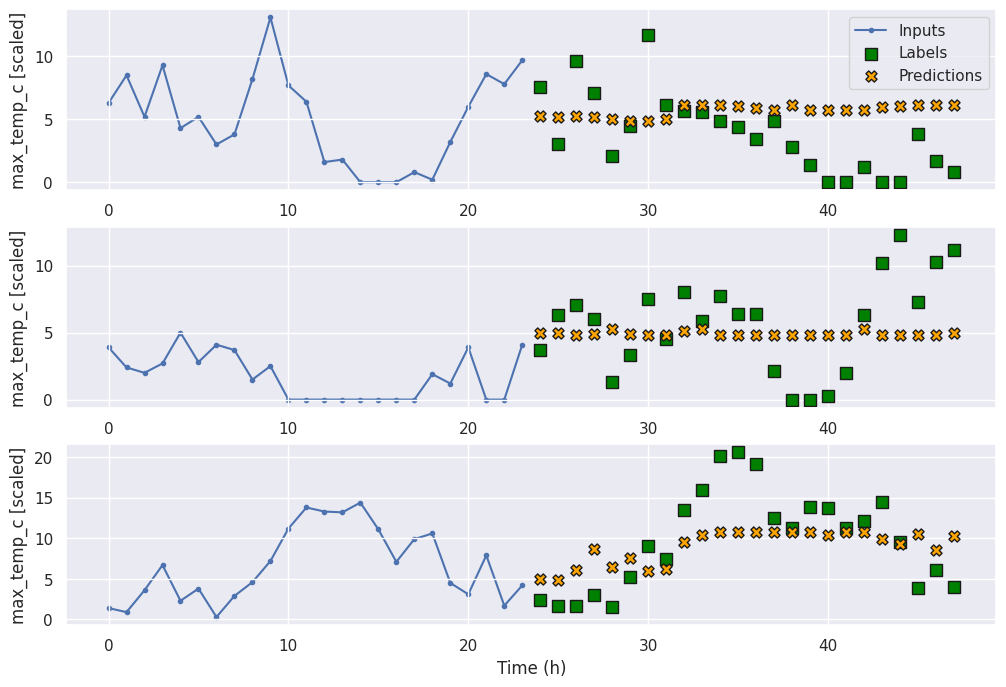

In [93]:
multi_window.plot(lstm_model)

### Prophet Forecast

sources: 

https://github.com/dipanjanS/practical-machine-learning-with-python/blob/master/notebooks/Ch11_Forecasting_Stock_and_Commodity_Prices/notebook_stock_prediction_fbprophet.ipynb
https://colab.research.google.com/drive/1Zz--8n9HsxHpNUm1GNFm2G4db3r7pKqR#scrollTo=0dd91ffd

In [94]:
cities_weather_pr = cities_weather_enc[["date", "max_temp_c"]]

In [95]:
cities_weather_pr.head(3)

date  max_temp_c
22024 1996-08-01        23.0
22025 1996-08-02        19.3
22026 1996-08-03        18.6

In [96]:
cities_weather_pr.columns = ['ds', 'y']

In [97]:
# prepare train and test sets
train_size_pr = int(cities_weather_pr.shape[0]*0.9)
train_pr = cities_weather_pr.iloc[:train_size_pr]
test_pr = cities_weather_pr.iloc[train_size_pr+1:]

In [98]:
# build a prophet model
m = Prophet()
m.fit(train_pr)

03:42:48 - cmdstanpy - INFO - Chain [1] start processing
03:44:38 - cmdstanpy - INFO - Chain [1] done processing


In [113]:
# prepare a future dataframe
#test_dates = m.make_future_dataframe(periods=test_pr.shape[0]) #works
test_dates = m.make_future_dataframe(4, freq='Y')
# forecast values
forecast = m.predict(test_dates)

In [114]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds      yhat  yhat_lower  yhat_upper
14949 2022-12-31  5.863543   -0.982740   12.805409
14950 2023-12-31  6.089669   -0.117166   13.453760
14951 2024-12-31  6.226801   -0.640534   13.078981
14952 2025-12-31  6.357475   -0.777990   13.853167
14953 2026-12-31  6.515295   -0.957395   14.056773

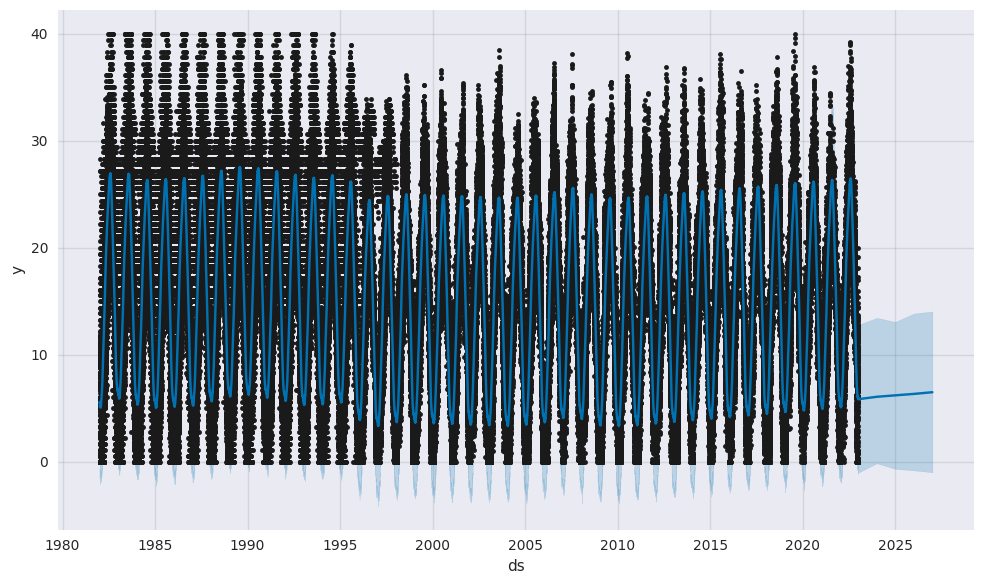

In [120]:
fig1 = m.plot(forecast)

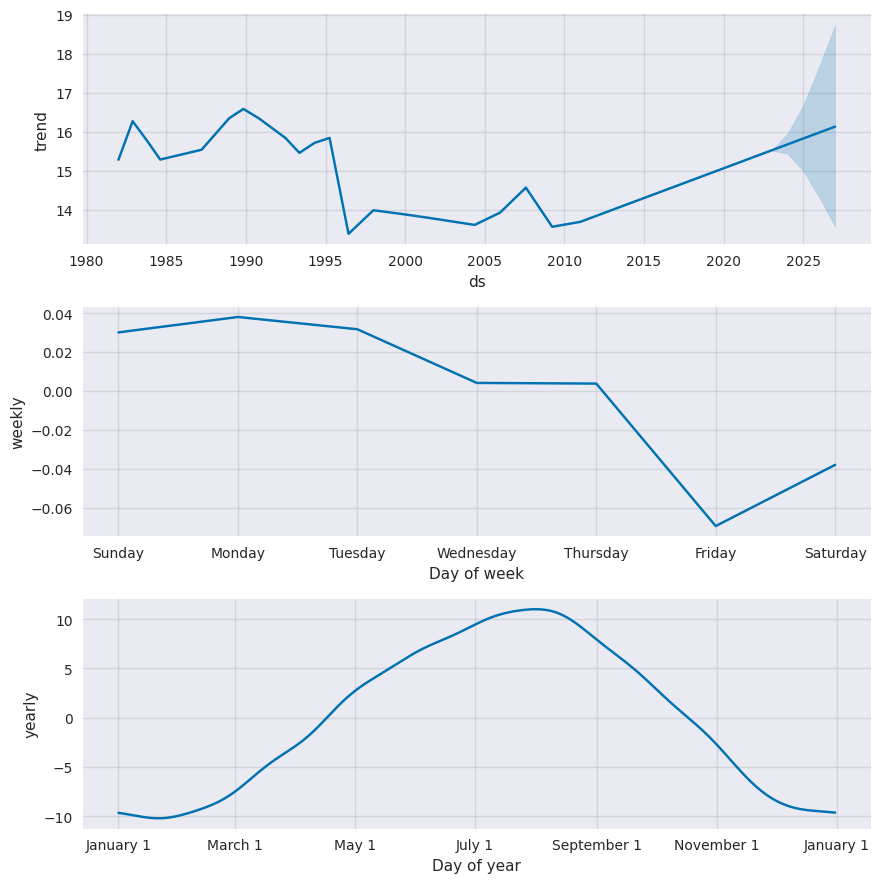

In [121]:
fig2 = m.plot_components(forecast)

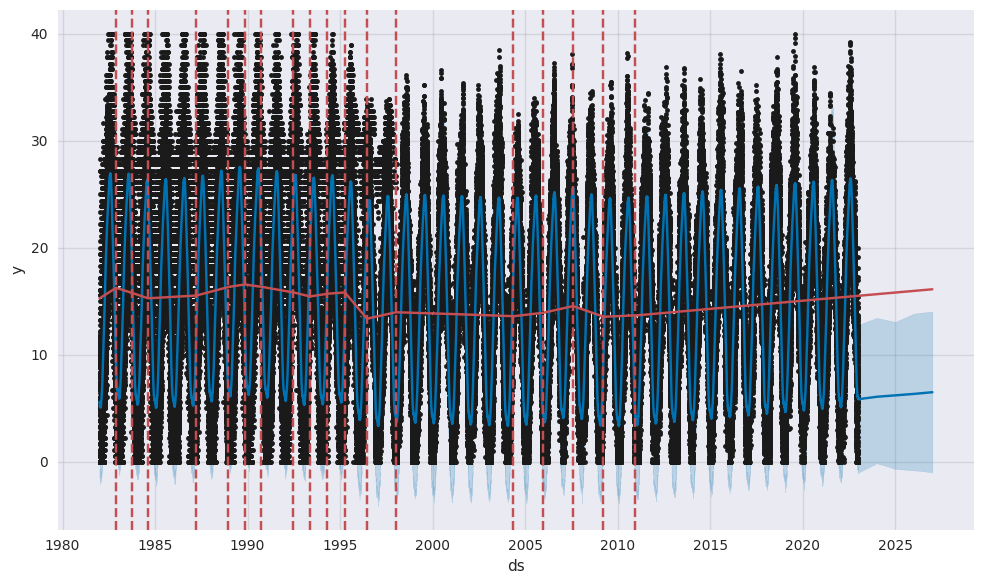

In [125]:
from prophet.plot import add_changepoints_to_plot

fig3 = m.plot(forecast)
a = add_changepoints_to_plot(fig3.gca(), m, forecast)

04:53:24 - cmdstanpy - INFO - Chain [1] start processing
04:55:21 - cmdstanpy - INFO - Chain [1] done processing


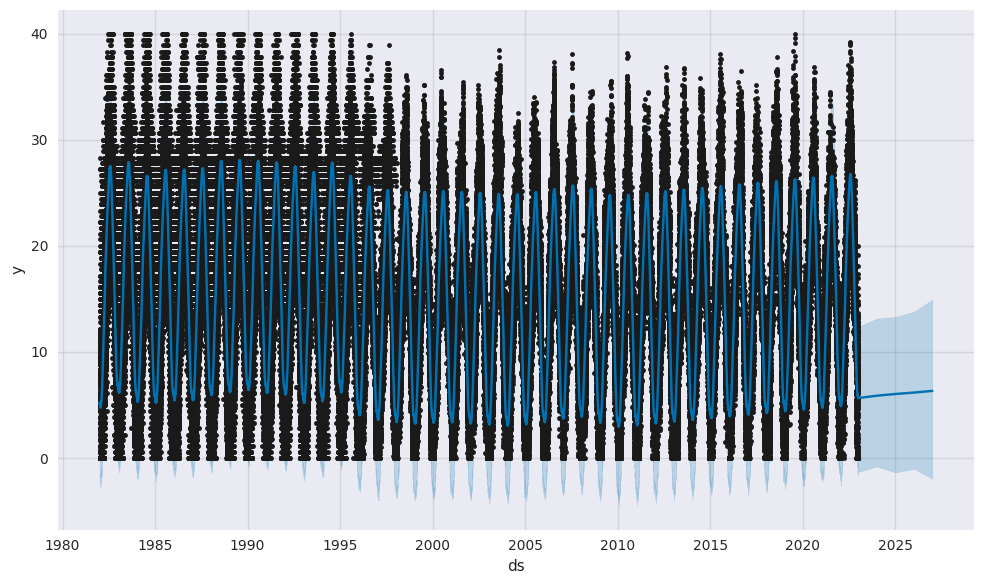

In [131]:
m = Prophet(changepoint_prior_scale=0.5)
forecast = m.fit(cities_weather_pr).predict(test_dates)
fig = m.plot(forecast)

04:56:04 - cmdstanpy - INFO - Chain [1] start processing
04:56:42 - cmdstanpy - INFO - Chain [1] done processing


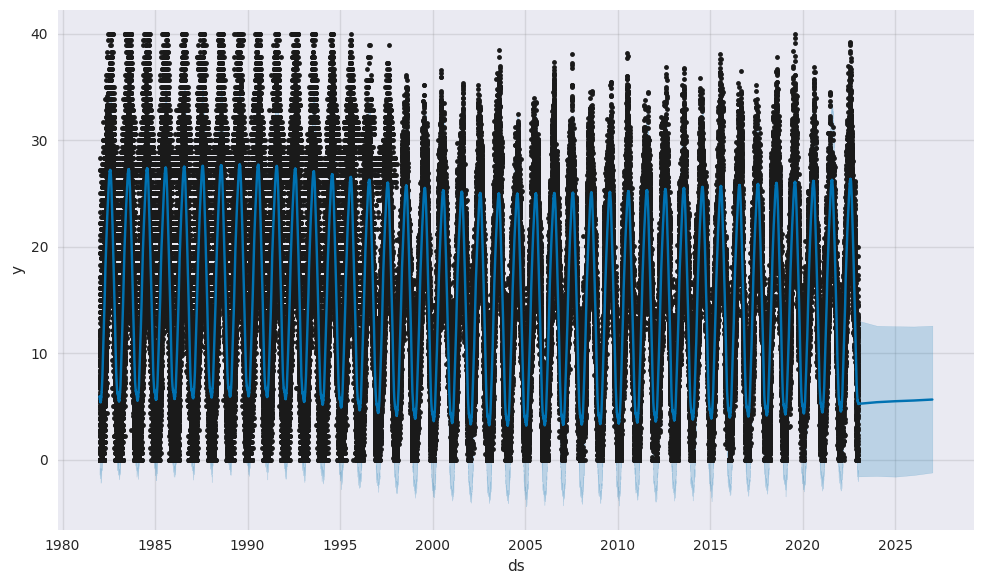

In [132]:
m = Prophet(changepoint_prior_scale=0.001)
forecast = m.fit(cities_weather_pr).predict(test_dates)
fig = m.plot(forecast)